# Running Model

Calibrated params from calibration_us_gdp.ipynb

/Users/ebbamark/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/collate_macro_vars.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['OBS_VALUE'] = hp_filter.hpfilter(subset['OBS_VALUE'], lamb=1600)[0]*.01+1


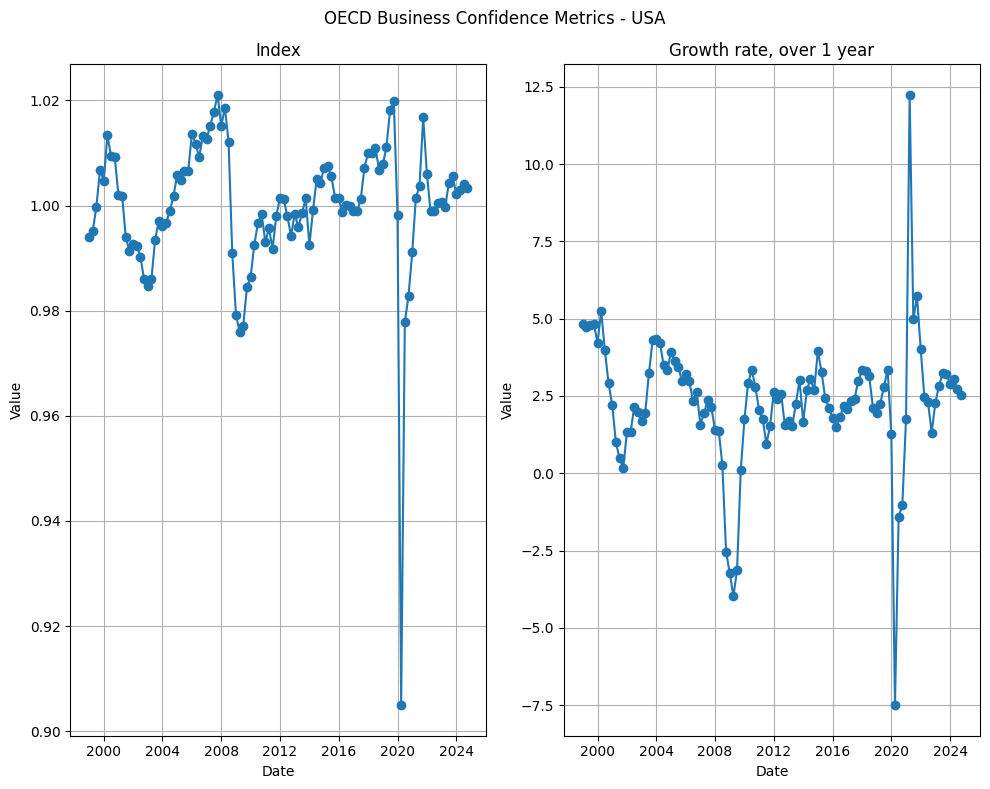

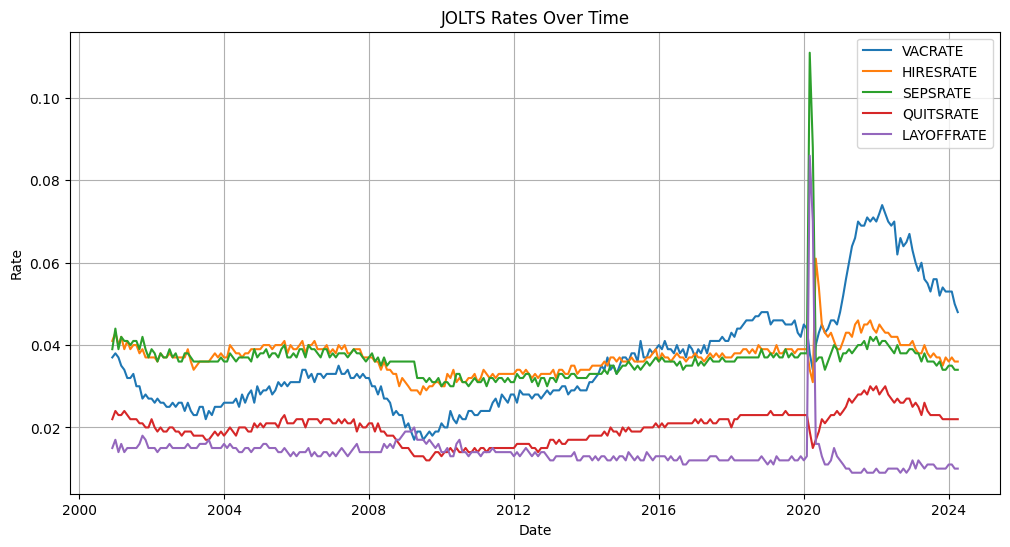

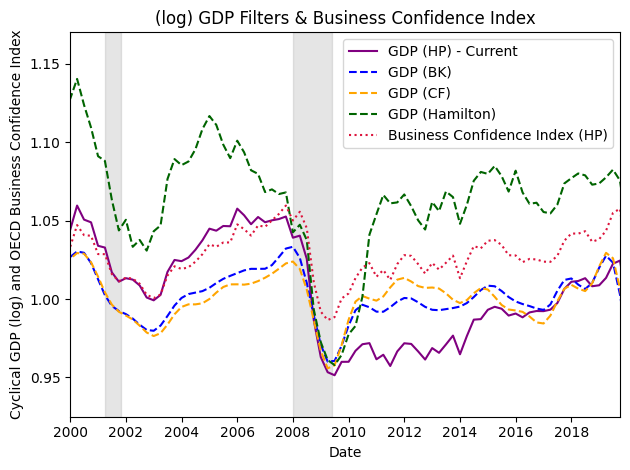

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

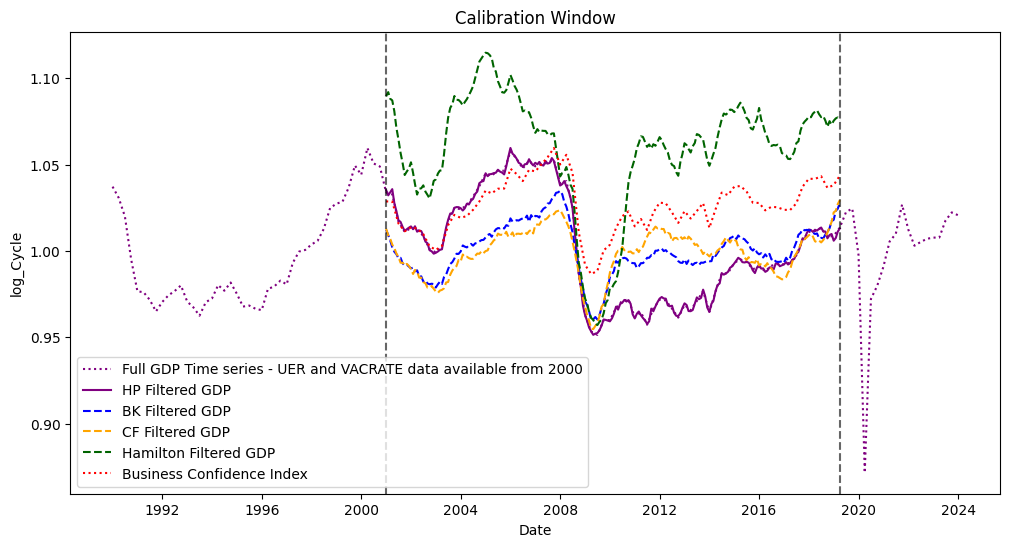

NEW Function import successful
8


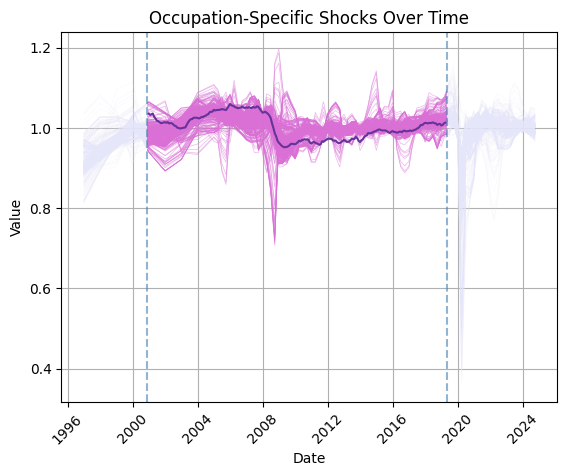

In [1]:
# Import packages
from abm_funs import *
from plot_funs import*
# from us_input import *
import numpy as np
from copy import deepcopy 
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from model_fun import *
from scipy.stats import pearsonr, linregress
import math as math
import importlib
from copy import deepcopy
from pandas import Series
import os
import seaborn as sns
import matplotlib.gridspec as gridspec
import datetime

from collate_macro_vars import *
from statsmodels.tsa.filters import hp_filter, bk_filter, cf_filter
from quantecon import hamilton_filter
from statsmodels.tsa.seasonal import seasonal_decompose
import csv

rng = np.random.default_rng()
test_fun()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/"

import os
print(os.cpu_count()) 

save_button = True

In [2]:
print(np.min(occ_shocks_dat))

0.708132334746154


0.8208768329587126


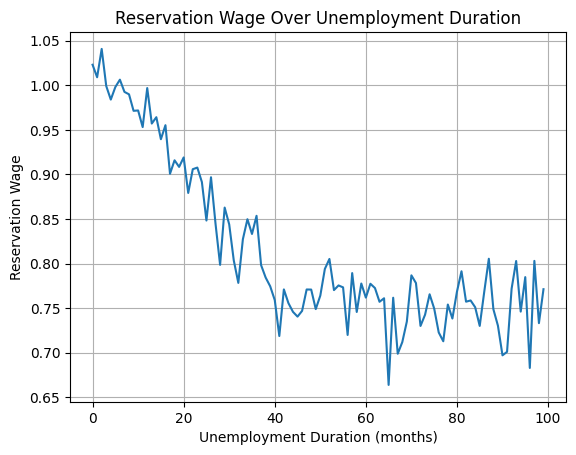

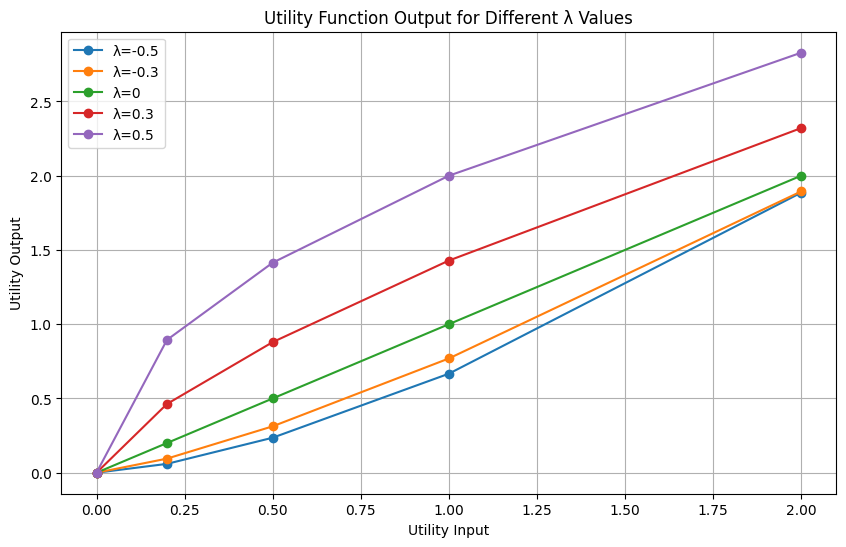

In [33]:
#### Reservation Wage Adjustment Rate ######
# Load the data
res_wage_dat = pd.read_csv(path + "data/res_wage_dists.csv")

# Main function: given duration and bin probabilities, return application count
def reservation_wage(duration_months,
                             res_wage_data,
                             expectation=False,
                             # Either lm (no sample balancing), glm, eb (entropy balancing)
                             balancing_method='lm'):
    """
    If expectation=True return the expected value (float);
    otherwise return a random draw (int).
    """
    if duration_months not in res_wage_data['dur_unemp'].values:
        #raise ValueError(f"No probability distribution for duration {duration_months}")
        res_wage = np.random.normal(loc=0.75, scale=np.max(res_wage_data[f'{balancing_method}_se']), size=1)[0]
        if expectation:
            res_wage = 0.75
    else:
        mean_val = res_wage_data[f'{balancing_method}_preds_fit'][res_wage_data['dur_unemp'] == duration_months]
        se_val = res_wage_data[f'{balancing_method}_se'][res_wage_data['dur_unemp'] == duration_months]

        if expectation:
            res_wage = mean_val.iloc[0]  # Extract scalar from Series
        else:
            res_wage = np.random.normal(loc=mean_val.iloc[0], scale=se_val.iloc[0], size=1)[0]
    
    return(res_wage)

print(reservation_wage(100, res_wage_dat, expectation = False, balancing_method = 'lm'))

res_wages = []
for i in range(100):
    res_wages.append(reservation_wage(i, res_wage_dat, expectation = False, balancing_method = 'lm'))

plt.plot(range(len(res_wages)), res_wages) 
plt.xlabel("Unemployment Duration (months)")
plt.ylabel("Reservation Wage")
plt.title("Reservation Wage Over Unemployment Duration")
plt.grid(True)
plt.show()

def utility_fun(lambda_param, utility):
    if lambda_param == 1:
        return(np.log(utility))
    else:
        return((utility**(1-lambda_param))/(1-lambda_param))

lambdas = [-0.5, -0.3, 0, 0.3, 0.5]
utilities = [0, 0.2, 0.5, 1, 2]

plt.figure(figsize=(10, 6))

for lambda_p in lambdas:
    utility_outputs = []
    for utility in utilities:
        utility_outputs.append(utility_fun(lambda_p, utility))
    plt.plot(utilities, utility_outputs, marker='o', label=f'λ={lambda_p}')

plt.xlabel('Utility Input')
plt.ylabel('Utility Output') 
plt.title('Utility Function Output for Different λ Values')
plt.grid(True)
plt.legend()
plt.show()


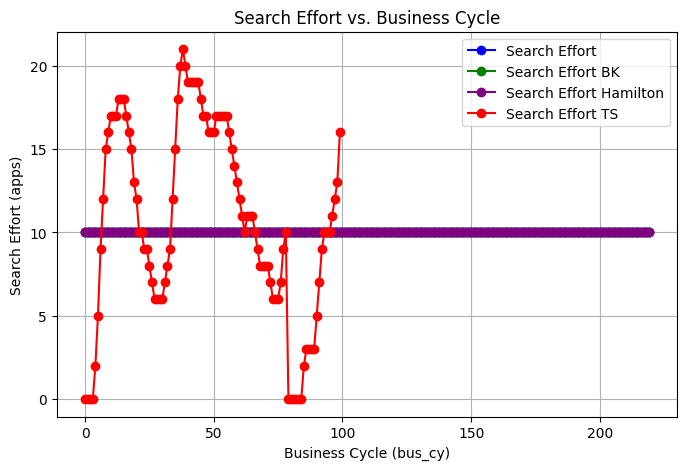

In [ ]:
# Search Effort Time Series
search_effort_dat = pd.read_csv("data/quarterly_search_ts.csv")
search_effort_dat['DATE'] = pd.to_datetime(search_effort_dat['year'].astype(str) + '-' + (search_effort_dat['quarter'] * 3 - 2).astype(str) + '-01')
search_effort_np = np.array(search_effort_dat['value_smooth'])
search_effort_np = search_effort_np/search_effort_np.mean()
#realgdp[(realgdp['DATE'] >= calib_date[0]) & (realgdp['DATE'] <= calib_date[1])]

# Define a range of bus_cy values  # Generates 100 values from 0 to 1
search_effort_values = [search_effort_alpha(0, b, False, 0.1) for b in gdp_dat]  # Apply function
search_effort_bk_values = [search_effort_alpha(0, b, False, 0.1) for b in gdp_dat_bk]  # Apply function
search_effort_hamilton_values = [search_effort_alpha(0, b, False, 0.1) for b in gdp_dat_hamilton]  # Apply function
# def search_effort_ts(t_unemp, se):
#     apps = max(0, round(10 - 100*(1-se)))
#     # if discouraged:
#     #     apps = round(a_stable/((t_unemp)**2 + 1)) + 1
#     return apps
search_effort_values_dyn = [search_effort_ts(0, b) for b in search_effort_np]

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(len(search_effort_values)), search_effort_values, marker='o', linestyle='-', color='b', label="Search Effort")
plt.plot(range(len(search_effort_bk_values)), search_effort_bk_values, marker='o', linestyle='-', color='g', label="Search Effort BK")
plt.plot(range(len(search_effort_hamilton_values)), search_effort_hamilton_values, marker='o', linestyle='-', color='purple', label="Search Effort Hamilton")

plt.plot(range(len(search_effort_values_dyn)), search_effort_values_dyn, marker='o', linestyle='-', color='r', label="Search Effort TS")
plt.xlabel("Business Cycle (bus_cy)")
plt.ylabel("Search Effort (apps)")
plt.title("Search Effort vs. Business Cycle")
plt.legend()
plt.grid(True)
plt.show()

We draw the probability distribution of sending a particular binned value of applications from our work on the BLS Suppelement. We assume a uniform distribution within each bin setting a maximum application effort in the highest bin to 100 applications. 

{'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 'y': [10, 10, 11, 12, 13, 14, 15, 16, 15, 14, 13, 12, 10, 9, 7, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 'y': [10, 10, 10, 11, 12, 12, 12, 13, 13, 13, 12, 12, 12, 11, 10, 10, 10, 9, 8, 8, 7, 6, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 'y': [10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 10, 10, 10, 10, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9]}


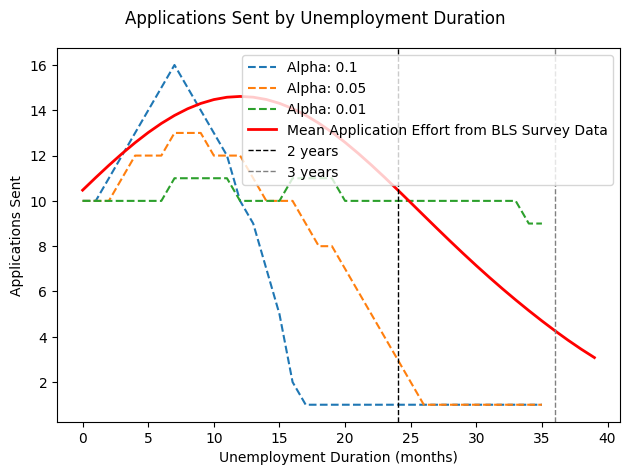

{'Alpha: 0.1': {'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 'y': [10, 10, 11, 12, 13, 14, 15, 16, 15, 14, 13, 12, 10, 9, 7, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, 'Alpha: 0.05': {'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 'y': [10, 10, 10, 11, 12, 12, 12, 13, 13, 13, 12, 12, 12, 11, 10, 10, 10, 9, 8, 8, 7, 6, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, 'Alpha: 0.01': {'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 'y': [10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 10, 10, 10, 10, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9]}}


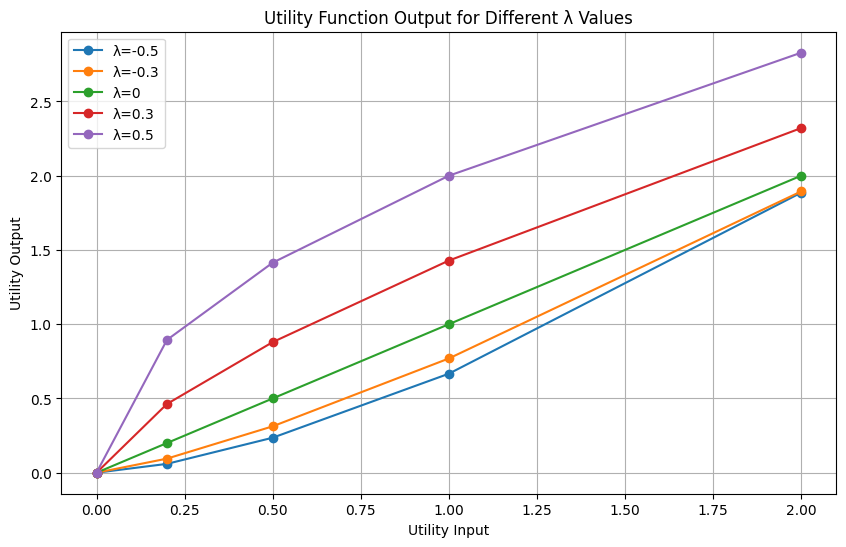

In [ ]:
series_dict = {}
for i, a in enumerate([0.1, 0.05, 0.01]):
    efforts = []
    for t_unemp in range(36):
        apps = search_effort_alpha(t_unemp, 1, True, a)
        efforts.append(apps)

    series_dict[f"Alpha: {a}"] = {
        "x": list(range(0, len(efforts))),
        "y": efforts
        }

imposed_efforts = []
for t_unemp in range(40):
    apps = applications_sent(duration_months=t_unemp, duration_to_prob_dict=duration_to_prob_dict, expectation = True)
    imposed_efforts.append(apps)

bls_df = {
    "x": list(range(0, len(imposed_efforts))),
    "y": imposed_efforts
    }

for i, a in series_dict.items():
    print(a)

    plt.plot(a['x'], a['y'],  linestyle='--', label=i)
    plt.xlabel("Unemployment Duration (months)")
    plt.ylabel("Applications Sent")
   
plt.plot(bls_df['x'], bls_df['y'], color='red', linestyle='-', linewidth=2, label='Mean Application Effort from BLS Survey Data')

plt.axvline(x=24, color='black', linestyle='--', linewidth=1, label='2 years')
plt.axvline(x=36, color='grey', linestyle='--', linewidth=1, label='3 years')
plt.legend(loc='upper right')
plt.suptitle("Applications Sent by Unemployment Duration")
plt.tight_layout()
plt.savefig('output/figures/applications_sent_by_unemployment_duration.png', dpi=300)
plt.show()

print(series_dict)


### Unemployed Search Effort Time Series

smoothing vac_df
220


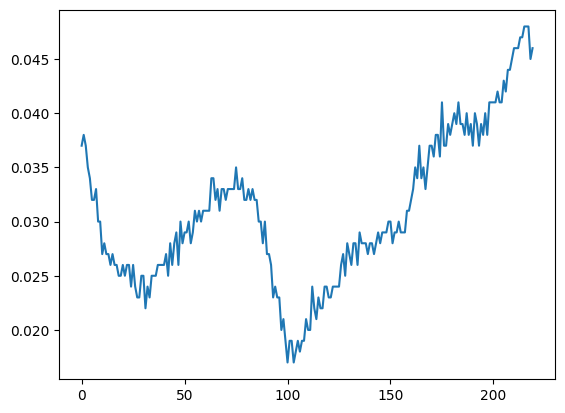

In [ ]:


# Macro observations
observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset=["UNRATE", "VACRATE"]).reset_index()
# Load US_input data
A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/10000)
# Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
unemployment = round(employment*(0.05/0.95))
# Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
# Needs input data...
demand_target = employment + vacancies
wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
occ_ids = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['id', 'acs_occ_code']]
gend_share = pd.read_csv(path+"data/ipums_variables_w_gender.csv")[['women_pct']]
mod_data =  {"A": A, "employment": employment, 
             'unemployment':unemployment, 'vacancies':vacancies, 
             'demand_target': demand_target, 'wages': wages, 'gend_share': gend_share}

###################################
# Initialise the model
##################################
net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), mod_data['gend_share'].to_numpy(), 0, 0)

# observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()
# Load calibrated parameters from CSV
param_df = pd.read_csv(path+"output/calibrated_params_all.csv")
# Sort by Timestamp in descending order
param_df = param_df.sort_values(by='Timestamp', ascending=False)

params = {'mod_data': mod_data, 
            'net_temp': net_temp,
            'vacs': vacs, 
            'time_steps': len(gdp_dat),
            'delay': 0,
            'gdp_data': gdp_dat,
            'app_effort_dat': duration_to_prob_dict,
            'occ_shocks_data': occ_shocks_dat}

# Shorten vac_df to the same length as gdp_dat using a moving average (if needed)   
vac_df = observation['VACRATE'].to_numpy()
if len(vac_df) > len(gdp_dat):
    print("smoothing vac_df")
    # Apply moving average with window to smooth and match length
    window = len(vac_df) // len(gdp_dat)
    vac_dat = Series(vac_df).rolling(window=window, min_periods=1).mean()[window-1::window].reset_index(drop=True)
    vac_dat = vac_dat[:len(gdp_dat)]
else:
    vac_dat = vac_df[:len(gdp_dat)]
    
print(len(vac_dat))
plt.plot(vac_dat, label="Vacancy Rate (smoothed)")


In [ ]:
# run_single_local(
#     d_u = 0.01, 
#     #d_v = 0.1,
#     gamma_u = 0.01,
#     #gamma_v = 0.1,
#     otj = True,
#     cyc_otj = True, 
#     cyc_ue = True, 
#     disc = True,
#     mod_data = mod_data, 
#     net_temp = net_temp, 
#     vacs = vacs, 
#     time_steps = len(gdp_dat), # set equal to length of gdp_data
#     delay = 100,
#     gdp_data = gdp_dat,
#     bus_confidence_dat = gdp_dat,
#     app_effort_dat = duration_to_prob_dict,
#     simple_res = False, 
#     vac_data = vac_dat
# )

In [ ]:
calib_list = {
    "nonbehav": {"otj": False, # has been run
                           "cyc_otj": False, 
                           "cyc_ue": False, 
                           "disc": False,
                           "delay": 100,
                           "bus_confidence_dat": gdp_dat,
                           'vac_data': vac_dat},
              "otj_nonbehav": {"otj": True, # has been run
                           "cyc_otj": False, 
                           "cyc_ue": False, 
                           "disc": False, 
                           "delay": 100,
                           "bus_confidence_dat": gdp_dat,
                            "vac_data": vac_dat},
            #   "otj_cyclical_e": {"otj": True,
            #                "cyc_otj": True, 
            #                "cyc_ue": False, 
            #                "disc": False,
            #                "bus_confidence_dat": gdp_dat},
            #   "otj_cyclical_ue": {"otj": True,
            #                "cyc_otj": False, 
            #                "cyc_ue": True, 
            #                "disc": False,
            #                "bus_confidence_dat": gdp_dat},
            #   "otj_cyclical_e_ue": {"otj": True,
            #                "cyc_otj": True, 
            #                "cyc_ue": True, 
            #                "disc": False,
            #                "bus_confidence_dat": gdp_dat},
              "otj_cyclical_e_disc": {"otj": True,
                           "cyc_otj": True, 
                           "cyc_ue": False, 
                           "disc": True,
                           "delay": 100,
                           "bus_confidence_dat": gdp_dat,
                           "vac_data": vac_dat},
            #   "otj_cyclical_ue_disc": {"otj": True,
            #                "cyc_otj": False, 
            #                "cyc_ue": True, 
            #                "disc": True,
            #                "bus_confidence_dat": gdp_dat},
              # "otj_cyclical_e_ue_disc": {"otj": True,
              #              "cyc_otj": True, 
              #              "cyc_ue": True, 
              #              "disc": True,
              #              "bus_confidence_dat": gdp_dat},
            "otj_disc": {"otj": True,
                          "cyc_otj": False, 
                          "cyc_ue": False, 
                          "disc": True,
                            "delay": 100,
                          "bus_confidence_dat": gdp_dat,
                          "vac_data": vac_dat}
            }

In [ ]:
# Initialize the results dictionaries
model_results = {}
net_results = {}
sim_results = {}
sum_stats_list = {}
seekers_recs = {}

print(param_df)
# Loop through each model configuration
for name, item in calib_list.items():
    print(name)
    # Create a deep copy of the base parameters
    test_params = deepcopy(params)

    # Update with values from param_df specific to the current model name
    if name in param_df['model_cat'].values:
        param_updates = param_df[param_df['model_cat'] == name].set_index('Parameter')['Value'].to_dict()
        print(param_updates)
        test_params.update(param_updates)

    # Update with the values from the calib_list
    test_params.update(item)
    
    # Run the model
    sim_record, sim_grouped, sim_net, sum_stats, seekers_rec = run_single_local(**test_params)

    # Generate plots or metrics (optional step)
    #ue_vac = plot_records(sim_record, calib_date[0], calib_date[1])
    sim_grouped['DATE'] = pd.date_range(start=calib_date[0], end= calib_date[1], periods=len(sim_grouped))
    sim_grouped['LTUE Rate'] = sim_grouped['LT Unemployed Persons'] / sim_grouped['Unemployment']
    sim_grouped['AVGWAGE'] = sim_grouped['Total_Wages'] / sim_grouped['Employment']
    sim_record['LTUE Rate'] = sim_record['LT Unemployed Persons'] / sim_record['Unemployment']
    sim_record['UER'] = sim_record['Unemployment'] / sim_record['Workers']
    sim_record['AVGWAGE'] = sim_record['Total_Wages'] / sim_record['Employment']
    sim_record['VACRATE1'] = sim_record['Vacancies'] / sim_record['Target_Demand']
    sim_record['VACRATE'] = sim_record['Vacancies'] / (sim_record['Vacancies'] + sim_record['Employment'])
    sim_record['U_REL_WAGE_MEAN'] = sim_record['U_Rel_Wage'] / sim_record['UE_Transitions']
    sim_record['E_REL_WAGE_MEAN'] = sim_record['E_Rel_Wage'] / sim_record['EE_Transitions']
    sim_record['UE_Trans_Rate'] = sim_record['UE_Transitions'] / sim_record['Workers']
    sim_record['EE_Trans_Rate'] = sim_record['EE_Transitions'] / sim_record['Workers']
    sim_record = sim_record.merge(occ_ids, left_on='Occupation', right_on="id", how='left')

    seekers_rec['DATE'] = pd.date_range(start=calib_date[0], end= calib_date[1], periods=len(seekers_rec))

    # Store the results
    model_results[name] = sim_grouped
    sim_results[name] = sim_record
    net_results[name] = sim_net
    sum_stats_list[name] = sum_stats
    seekers_recs[name] = seekers_rec

   Parameter     Value    otj  cyc_otj  cyc_ue   disc            Timestamp  \
10       d_u  0.001965   True    False   False   True  2025-06-26 02:39:00   
11   gamma_u  0.005895   True    False   False   True  2025-06-26 02:39:00   
8        d_u  0.002340   True     True   False   True  2025-06-26 01:50:24   
9    gamma_u  0.005114   True     True   False   True  2025-06-26 01:50:24   
6        d_u  0.000352   True    False   False  False  2025-06-26 00:59:51   
7    gamma_u  0.617953   True    False   False  False  2025-06-26 00:59:51   
4        d_u  0.007198  False    False   False  False  2025-06-26 00:04:50   
5    gamma_u  0.647185  False    False   False  False  2025-06-26 00:04:50   
2        d_u  0.006155   True    False   False   True  2025-06-25 17:37:29   
3    gamma_u  0.020735   True    False   False   True  2025-06-25 17:37:29   
0        d_u  0.007504   True     True   False   True  2025-06-25 17:17:15   
1    gamma_u  0.018580   True     True   False   True  2025-06-2

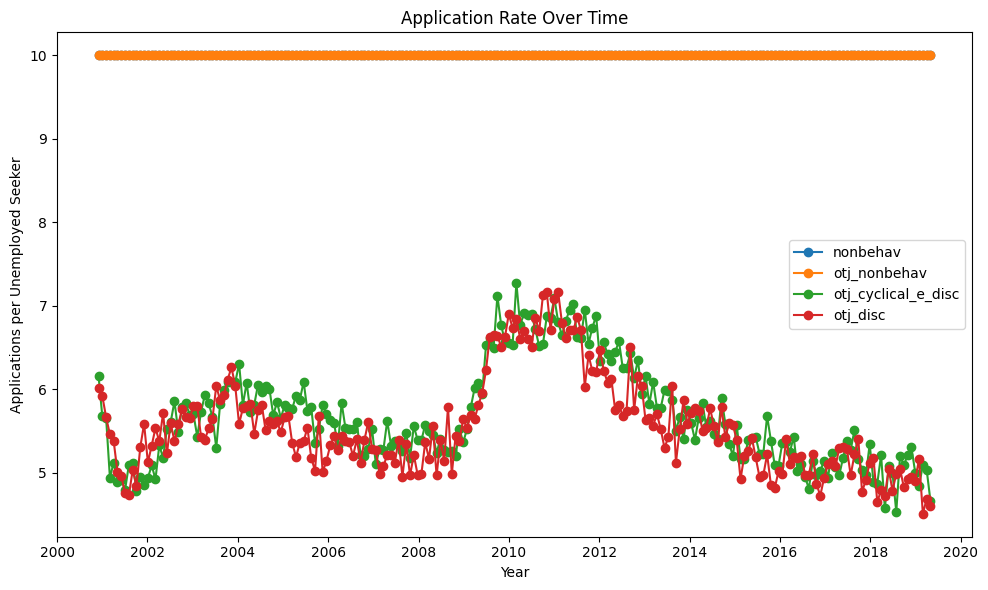

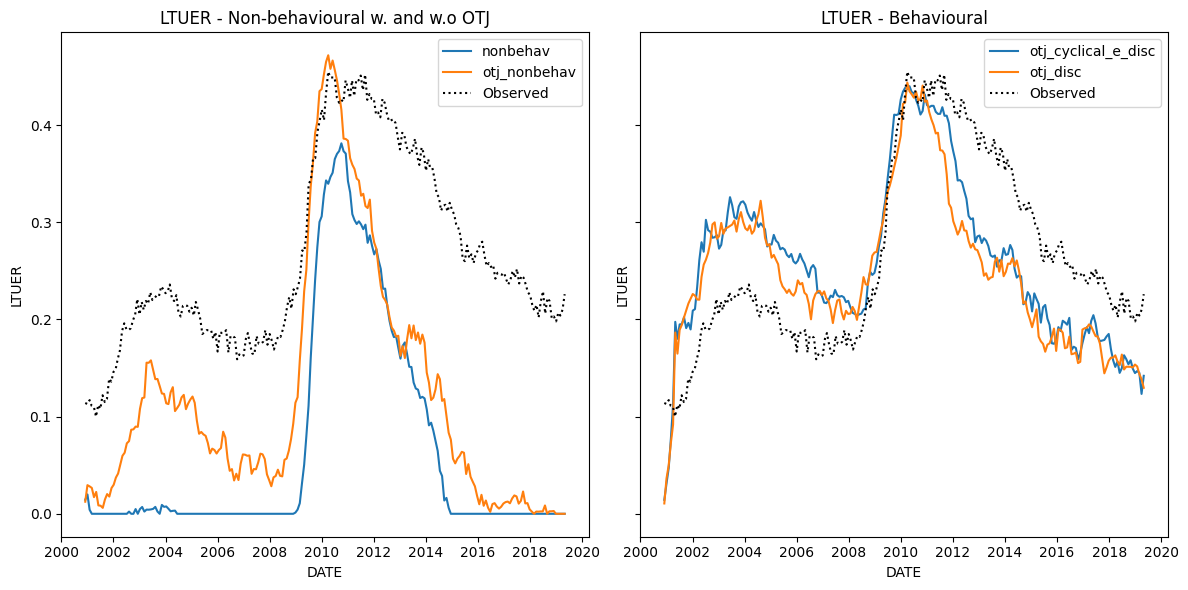

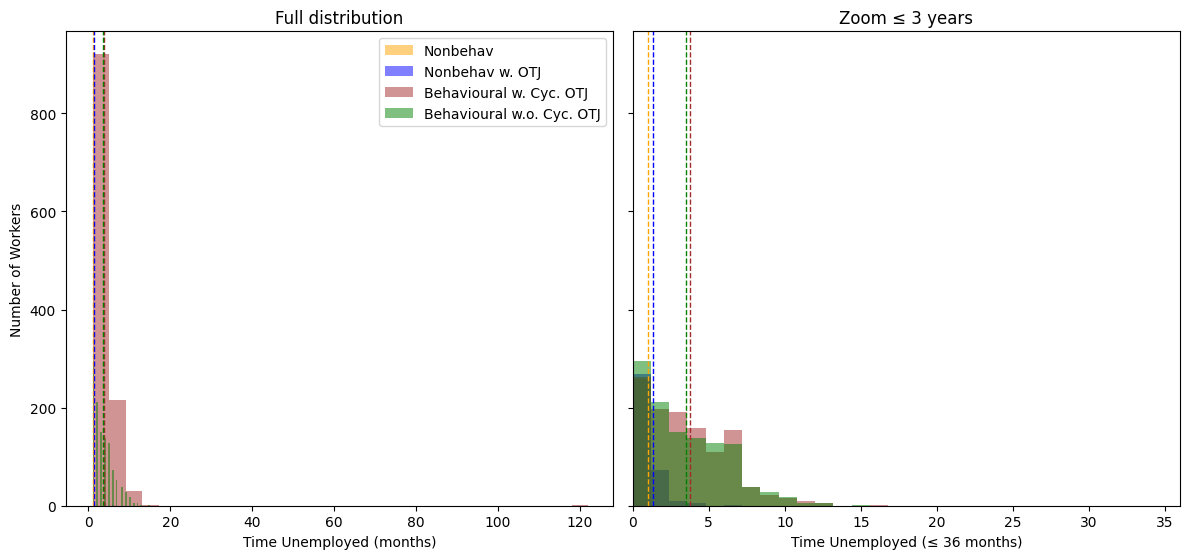

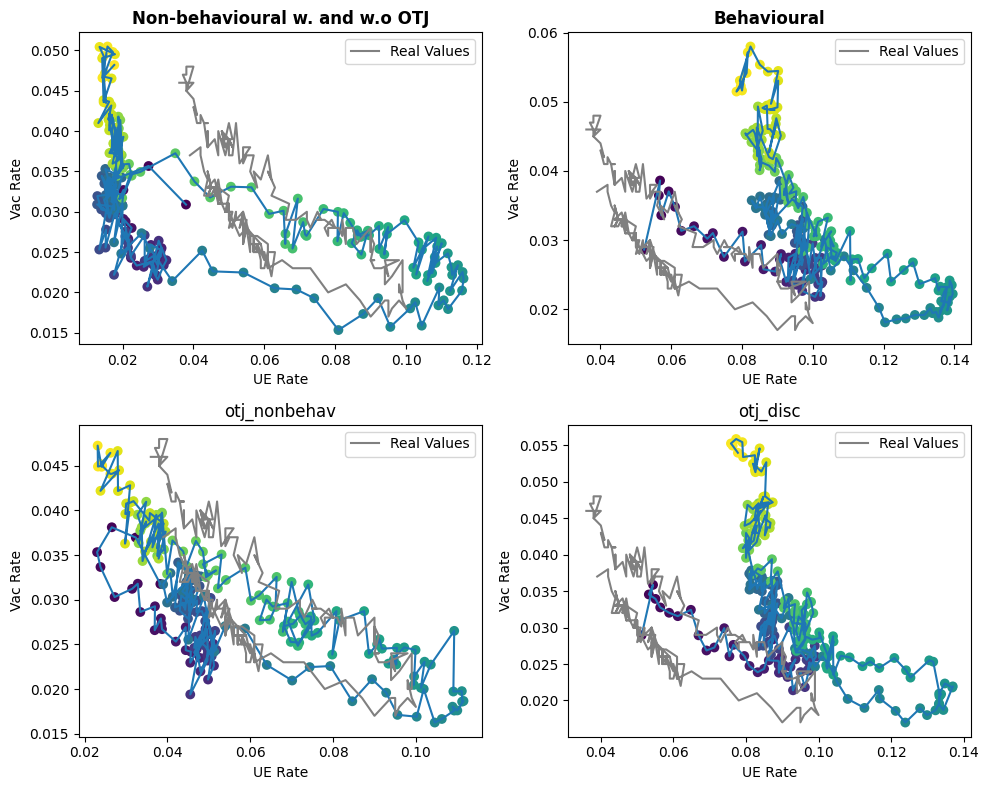

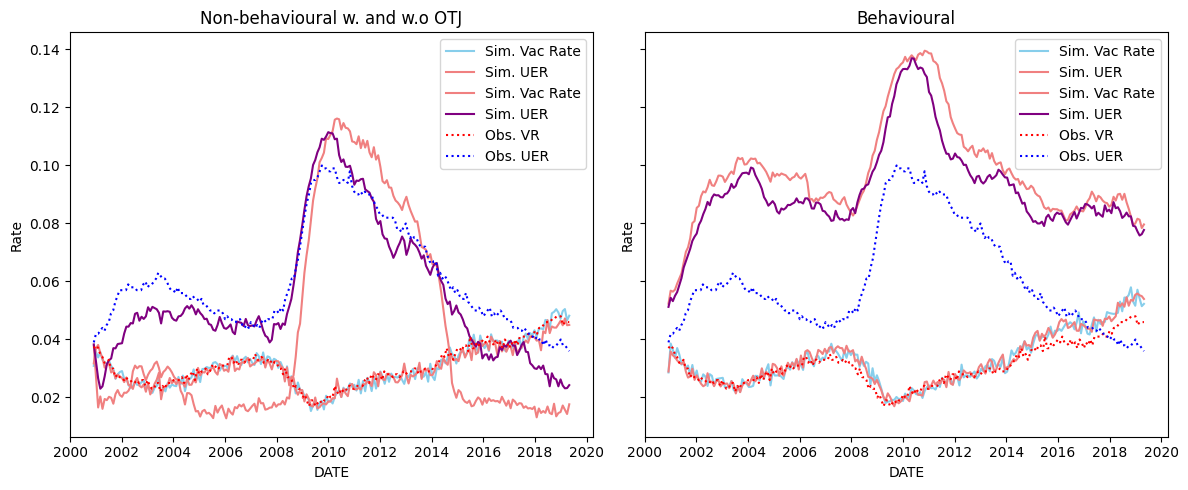

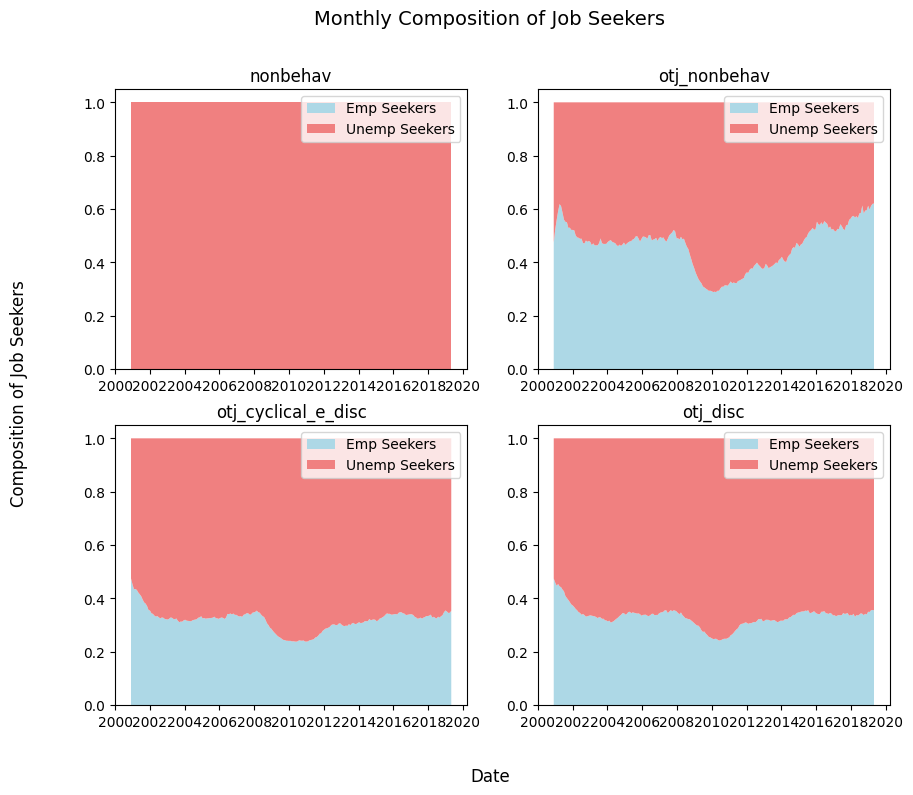

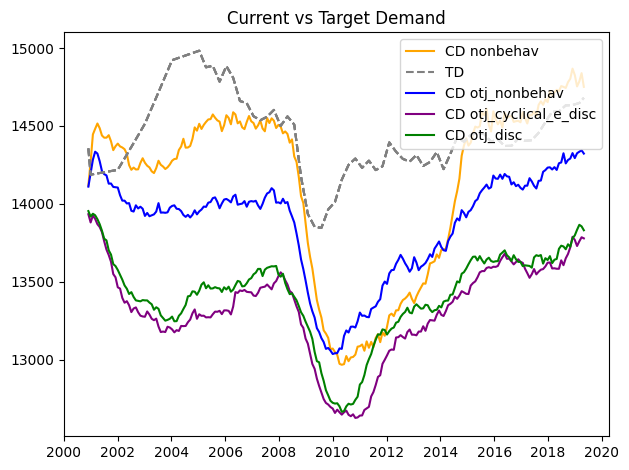

In [ ]:
output_path = "output/figures/"
filtered_model_results = {key: model_results[key] for key in ["nonbehav","otj_nonbehav", "otj_cyclical_e_disc", 'otj_disc'] if key in model_results}
filtered_net_results = {key: net_results[key] for key in ["nonbehav","otj_nonbehav", "otj_cyclical_e_disc", 'otj_disc'] if key in net_results}
filtered_sim_results = {key: sim_results[key] for key in ["nonbehav","otj_nonbehav", "otj_cyclical_e_disc", 'otj_disc'] if key in sim_results}
filtered_sum_stats = {key: sum_stats_list[key] for key in ["nonbehav","otj_nonbehav", "otj_cyclical_e_disc", 'otj_disc'] if key in sum_stats_list}

plt.figure(figsize=(10, 6))
for i, (name, item) in enumerate(seekers_recs.items()):
    plt.plot(item['DATE'], item['Applications Sent'] / item['Unemployed Seekers'], marker='o', label=name)
plt.xlabel('Year')
plt.ylabel('Applications per Unemployed Seeker')
plt.title('Application Rate Over Time')
plt.tight_layout()
plt.legend()
plt.savefig(f'{output_path}applications_per_unemployed_seeker.png')
plt.show()

plot_ltuer(filtered_model_results, observation, sep_strings = [("nonbehav", "Non-behavioural w. and w.o OTJ"), ("disc", "Behavioural")], sep = True, save = save_button, path = output_path)
plot_ltuer_dist(filtered_net_results, gender = False, names = ["Nonbehav", "Nonbehav w. OTJ", "Behavioural w. Cyc. OTJ","Behavioural w.o. Cyc. OTJ"], save = save_button, path = output_path)
plot_bev_curve(filtered_model_results, observation, sep_strings = [("nonbehav", "Non-behavioural w. and w.o OTJ"), ("disc", "Behavioural")], sep = True, save = save_button, path = output_path)
plot_uer_vac(filtered_model_results, observation, sep_strings = [("nonbehav", "Non-behavioural w. and w.o OTJ"), ("disc", "Behavioural")], sep = True, save = save_button, path = output_path)
plot_seeker_comp(filtered_model_results, sep = True, share = True, save = save_button, path = output_path)
plot_cd_vs_td(filtered_model_results, save = save_button, path = output_path)


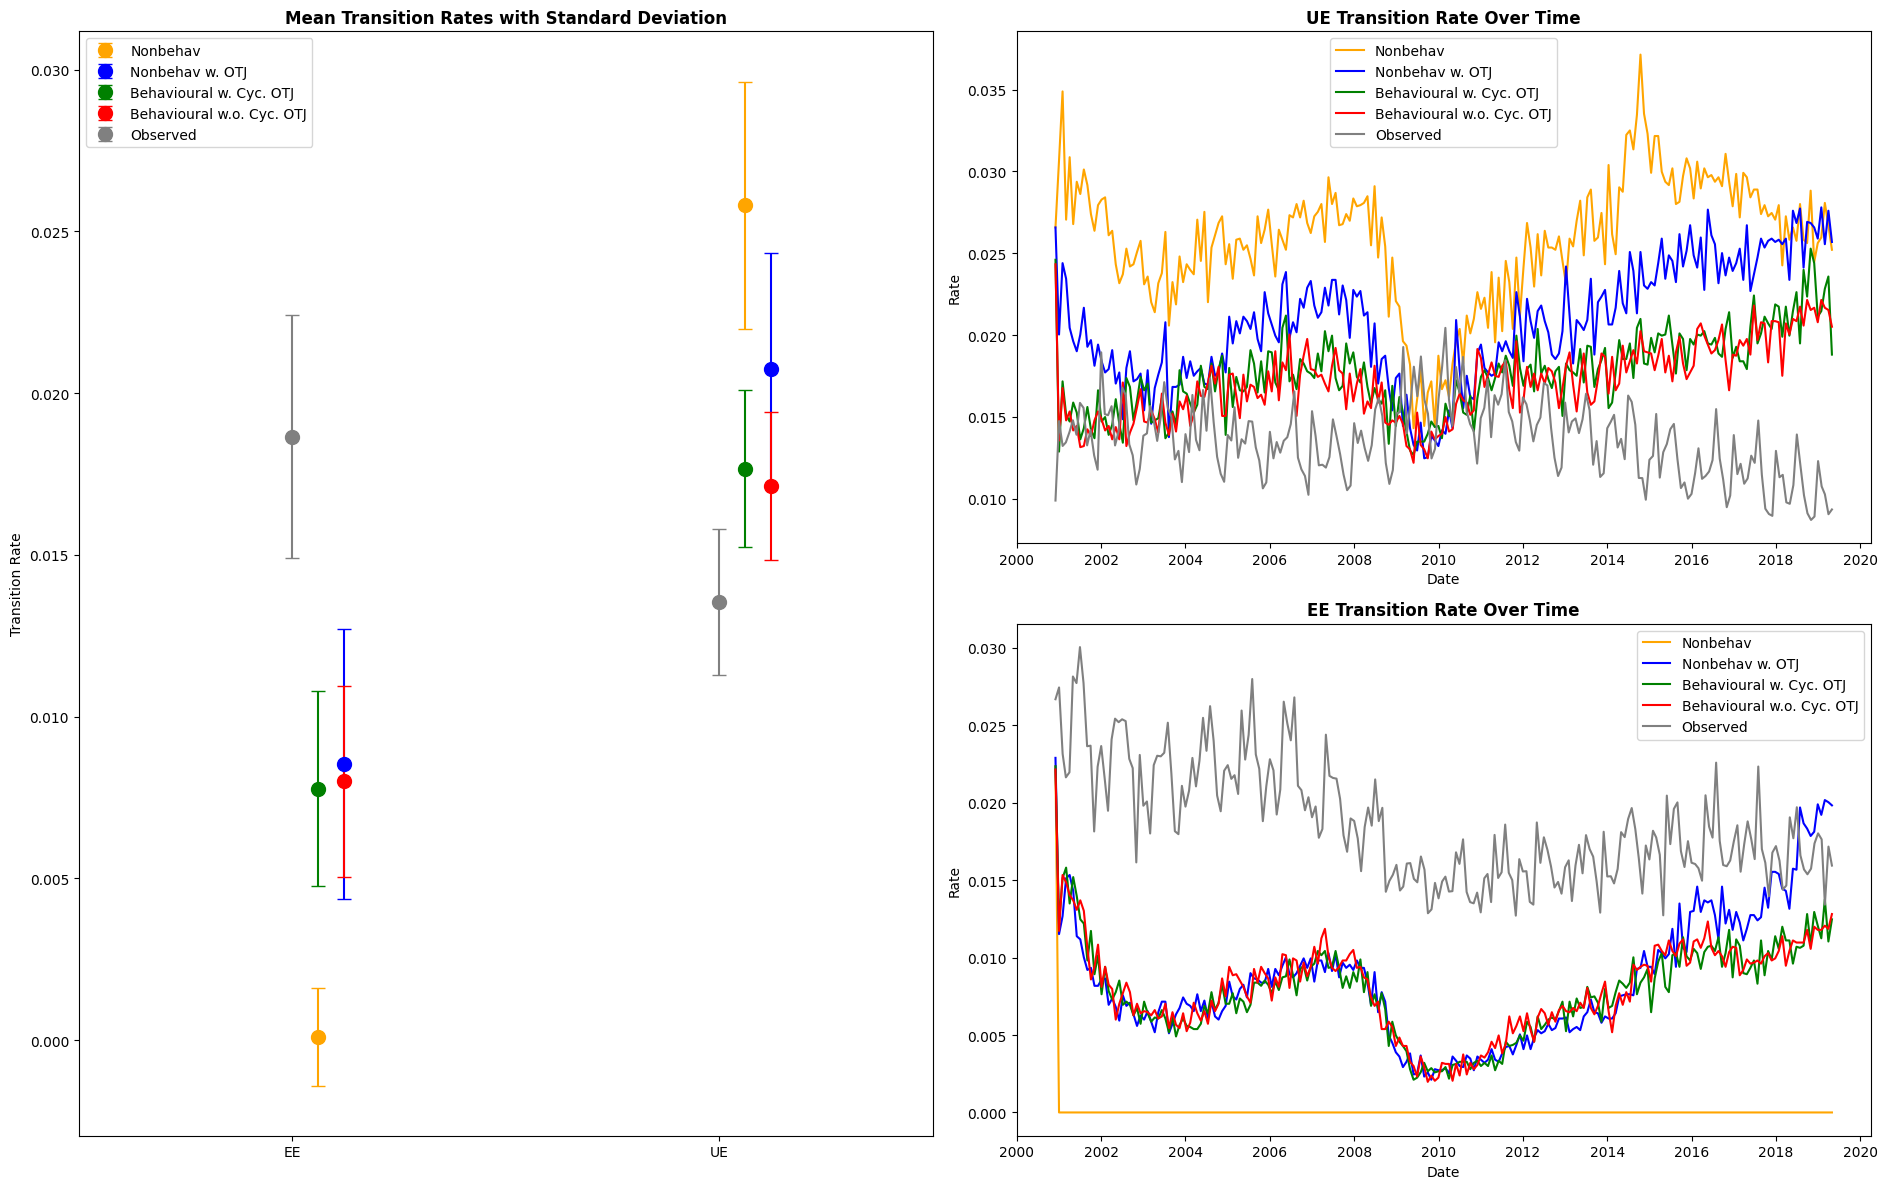

/Users/ebbamark/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/plot_funs.py:225: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  annual_data = res.set_index('DATE').resample(freq).mean()


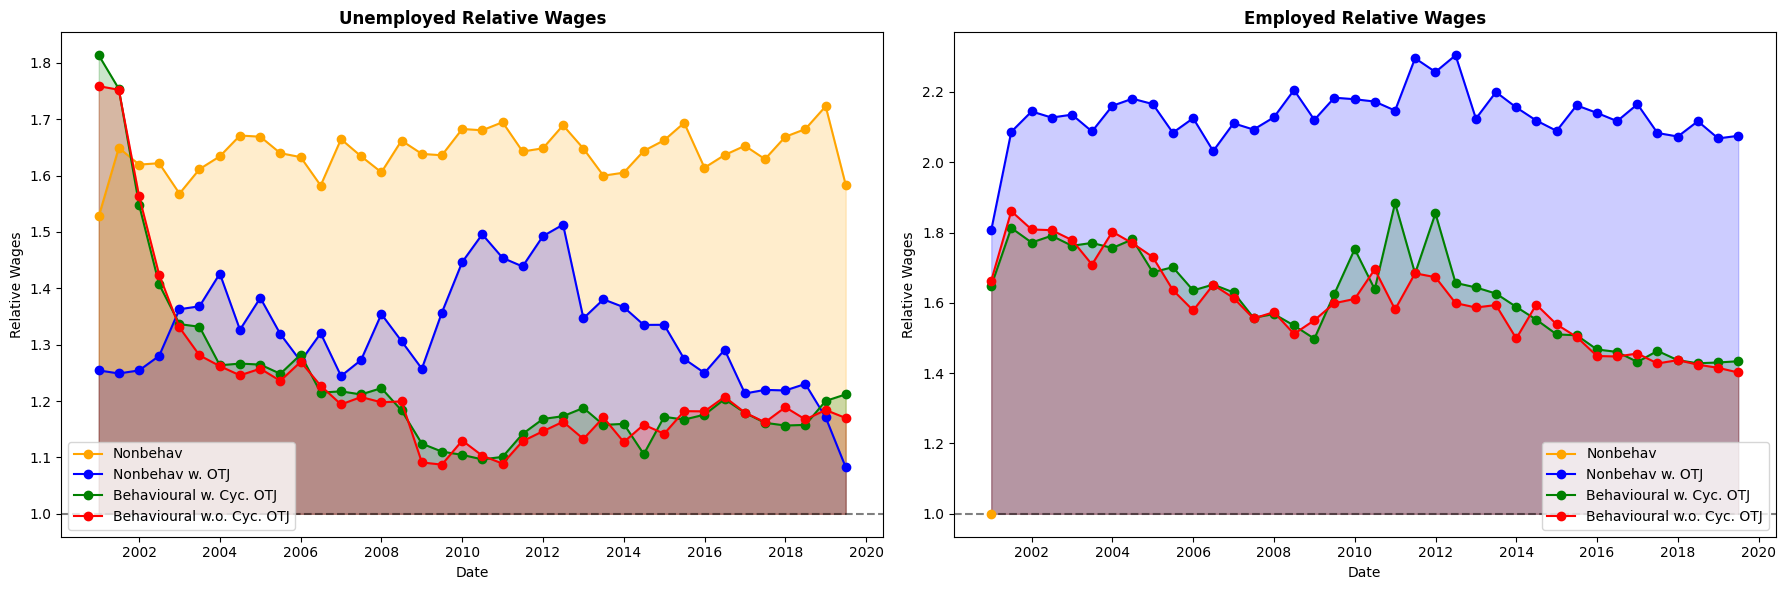

In [ ]:
# moved to macro-vars folder from  data/behav_params/Eeckhout_Replication/cps_data/transition_rates_96_24.csv' - created in grouped_transition_rates.R script
all_rates_new = pd.read_csv('data/transition_rates_96_24.csv')
all_rates_new = all_rates_new[(all_rates_new['date'] >= calib_date[0]) & (all_rates_new['date'] <= calib_date[1])]
all_rates_new['DATE'] = pd.to_datetime(all_rates_new['date'])


plot_trans_rates(filtered_model_results, observation = all_rates_new, names = ["Nonbehav", "Nonbehav w. OTJ", "Behavioural w. Cyc. OTJ","Behavioural w.o. Cyc. OTJ"], save = save_button, path = output_path)
plot_rel_wages(filtered_model_results, names = ["Nonbehav", "Nonbehav w. OTJ", "Behavioural w. Cyc. OTJ","Behavioural w.o. Cyc. OTJ"], save = save_button, path = output_path, freq = '6M')

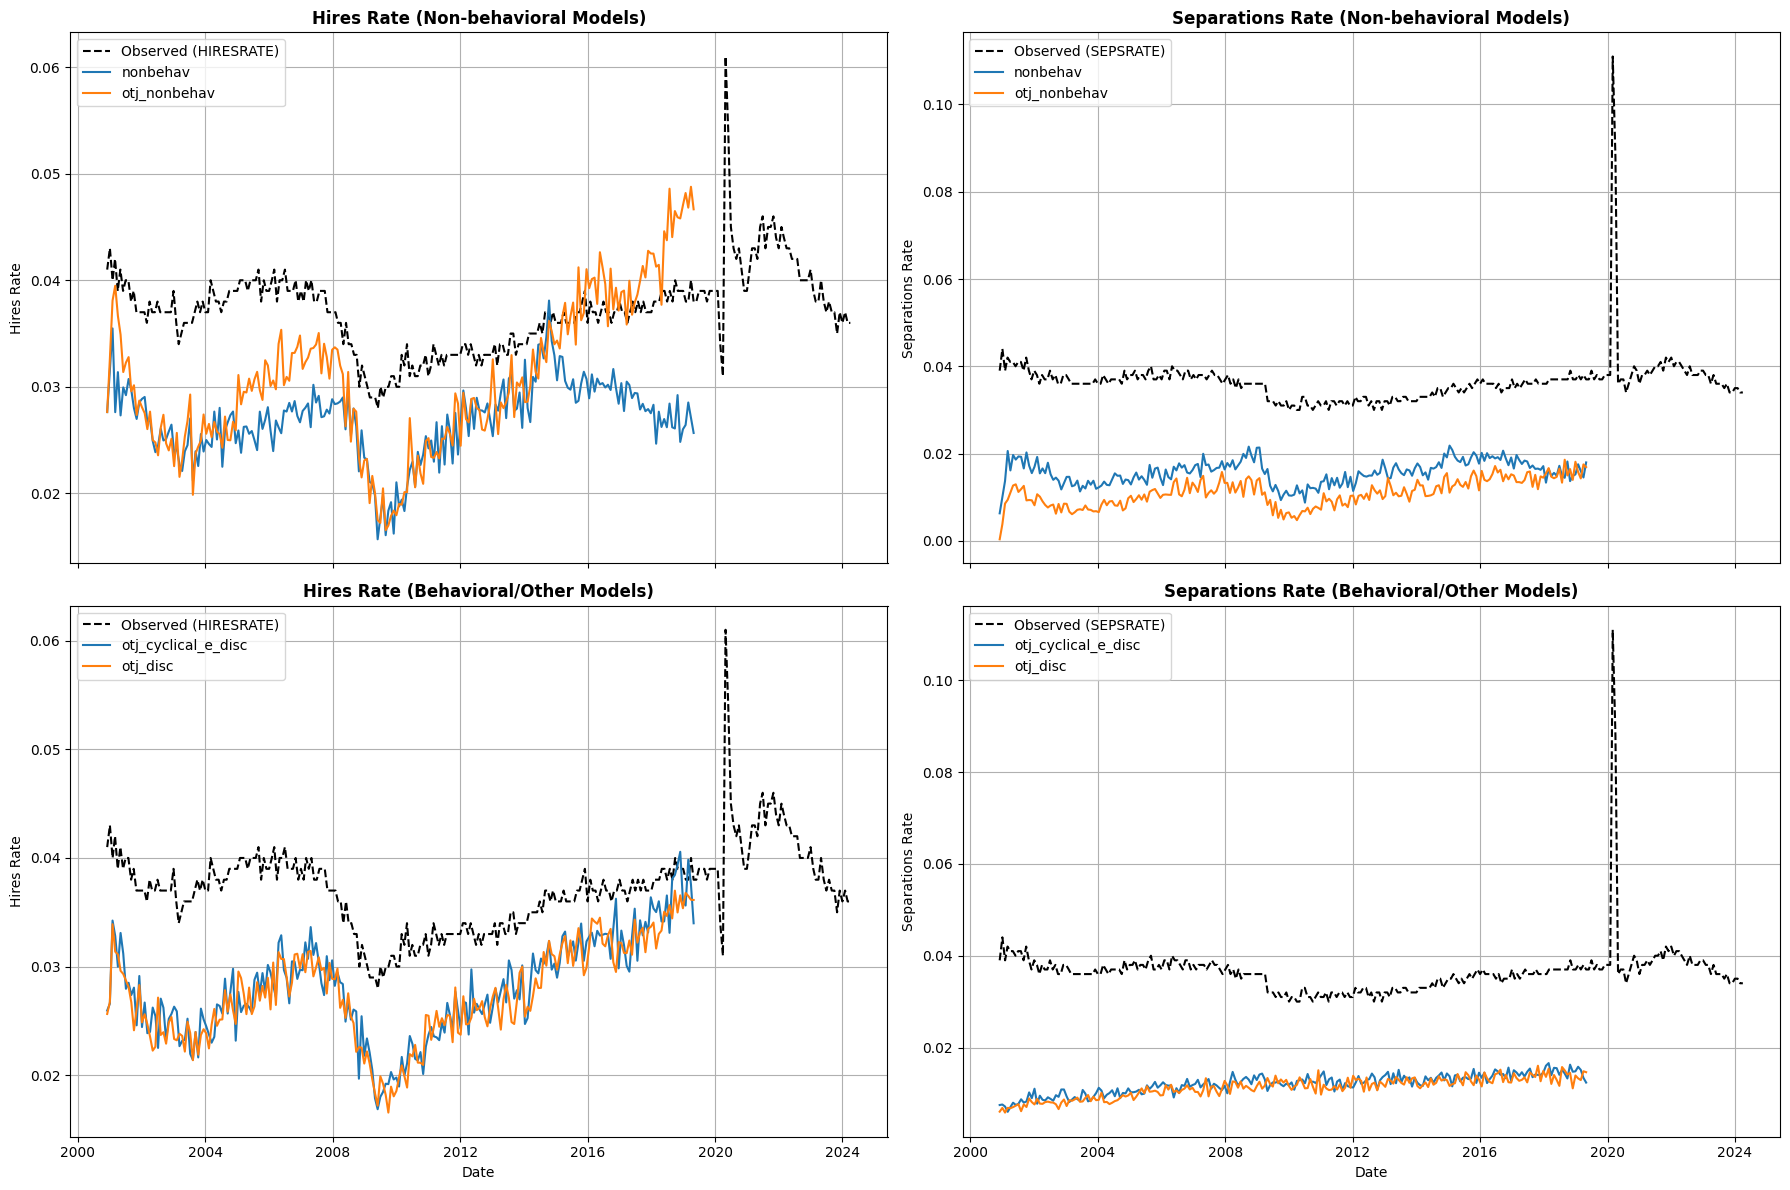

In [ ]:
hires_seps_rate(filtered_model_results, save = save_button, path = output_path)

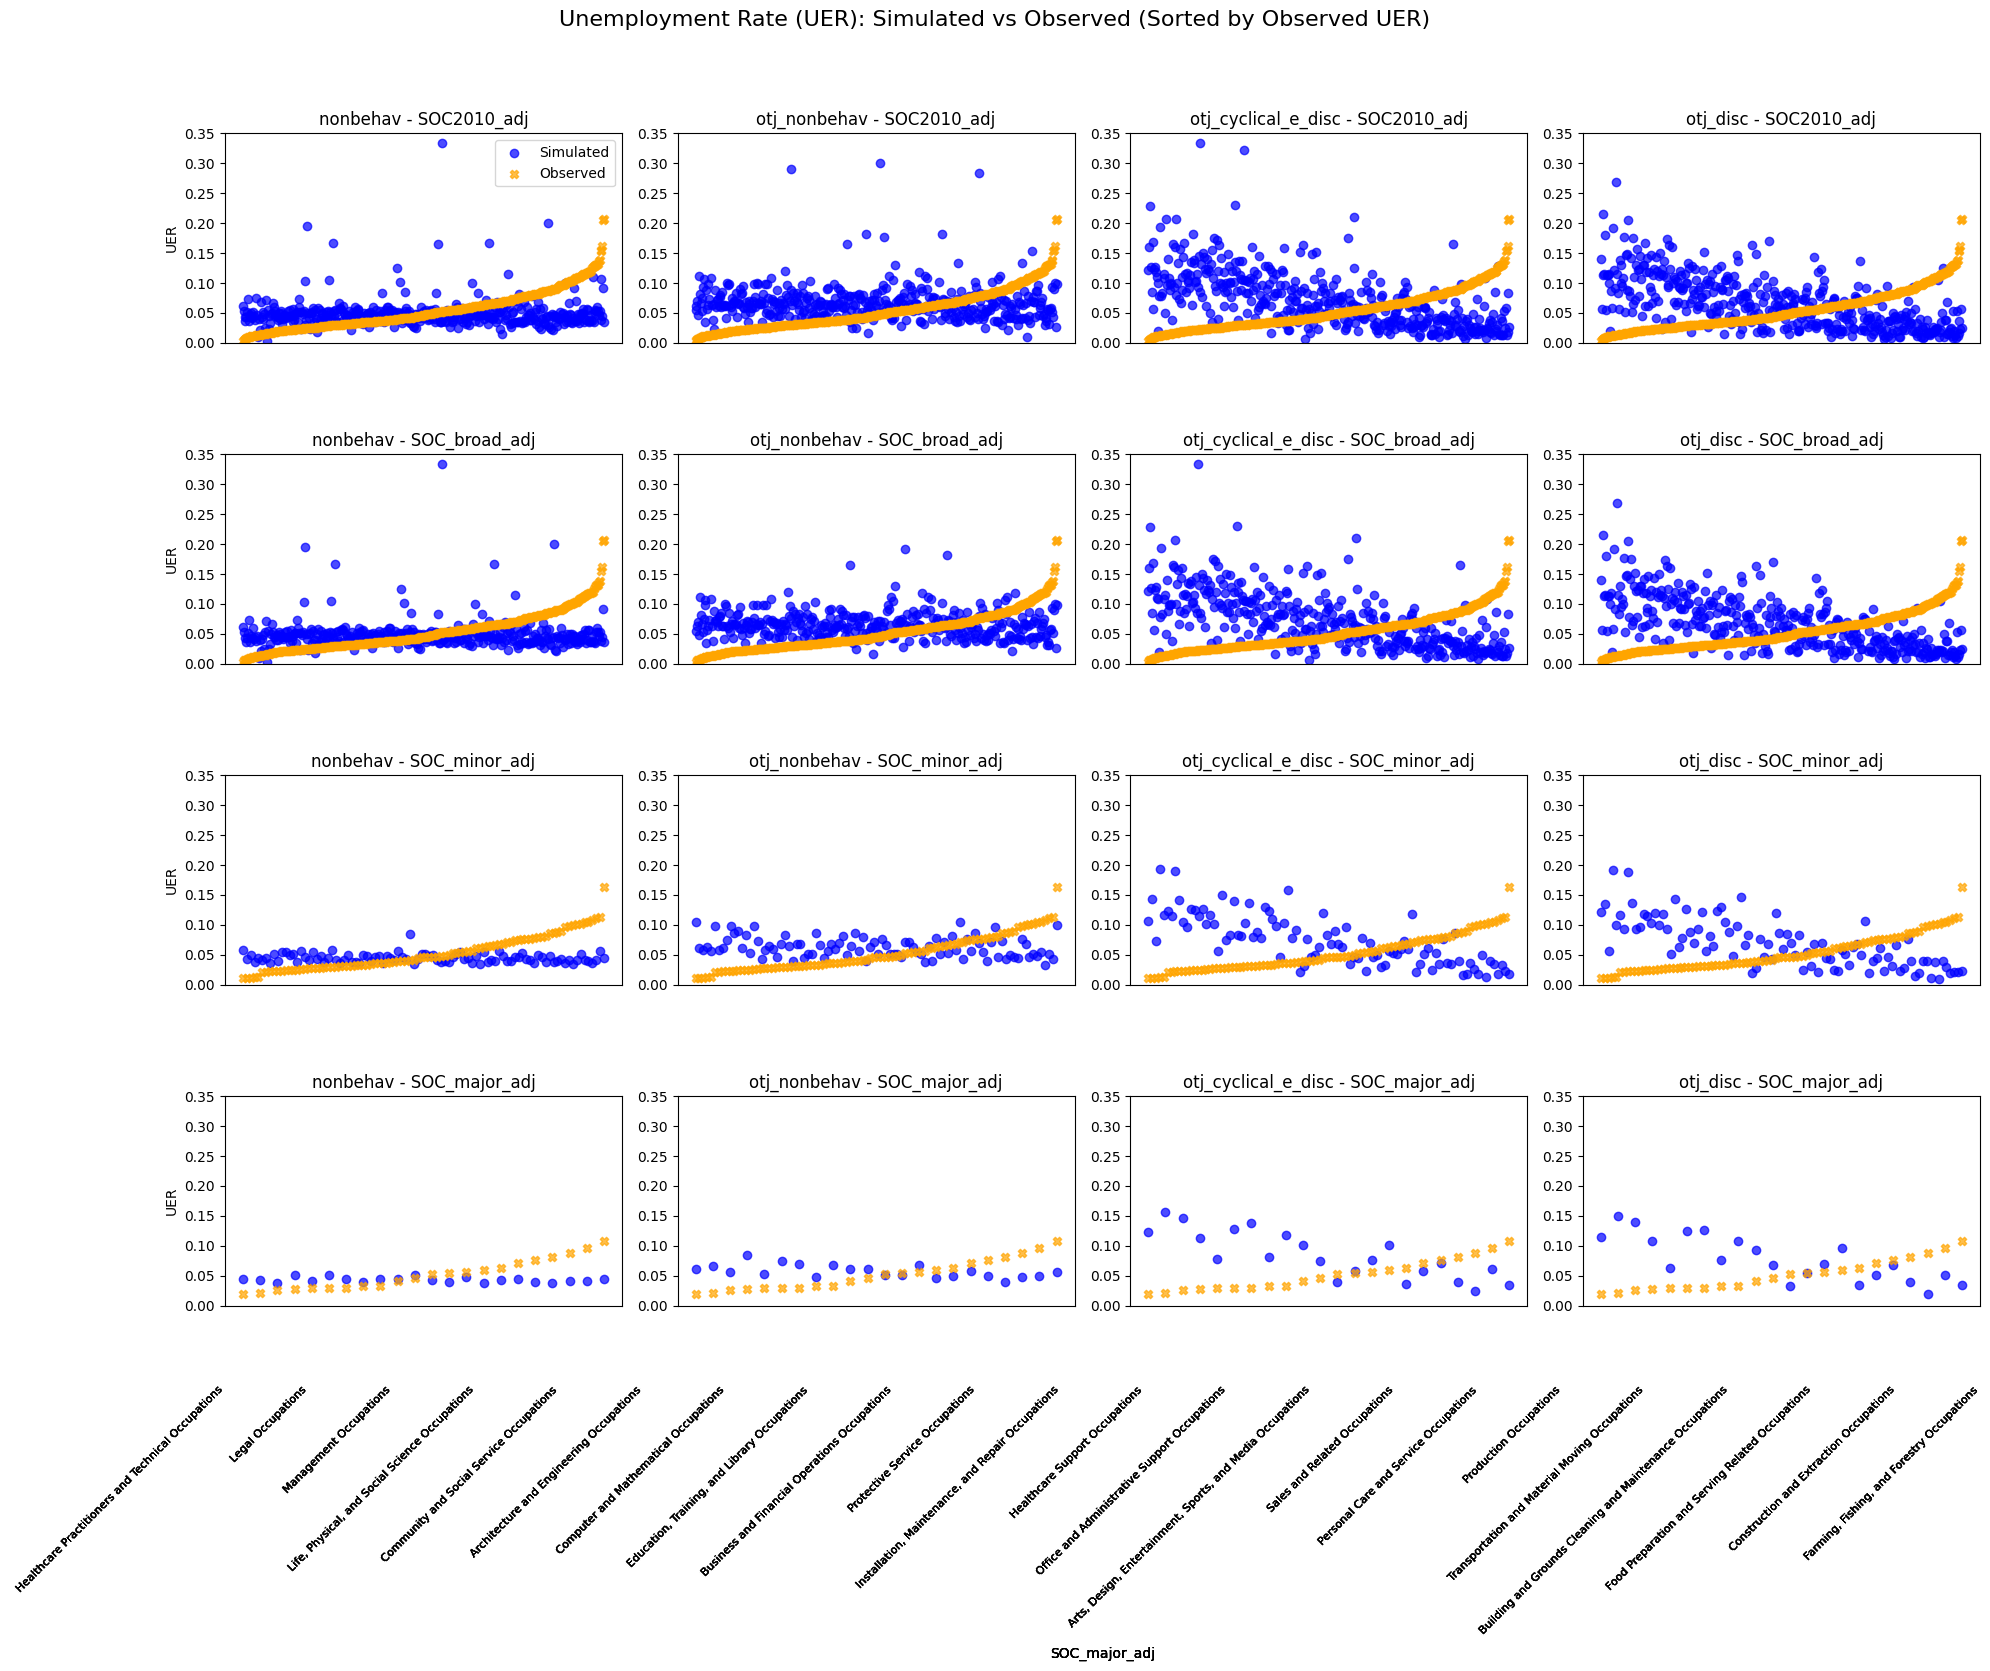

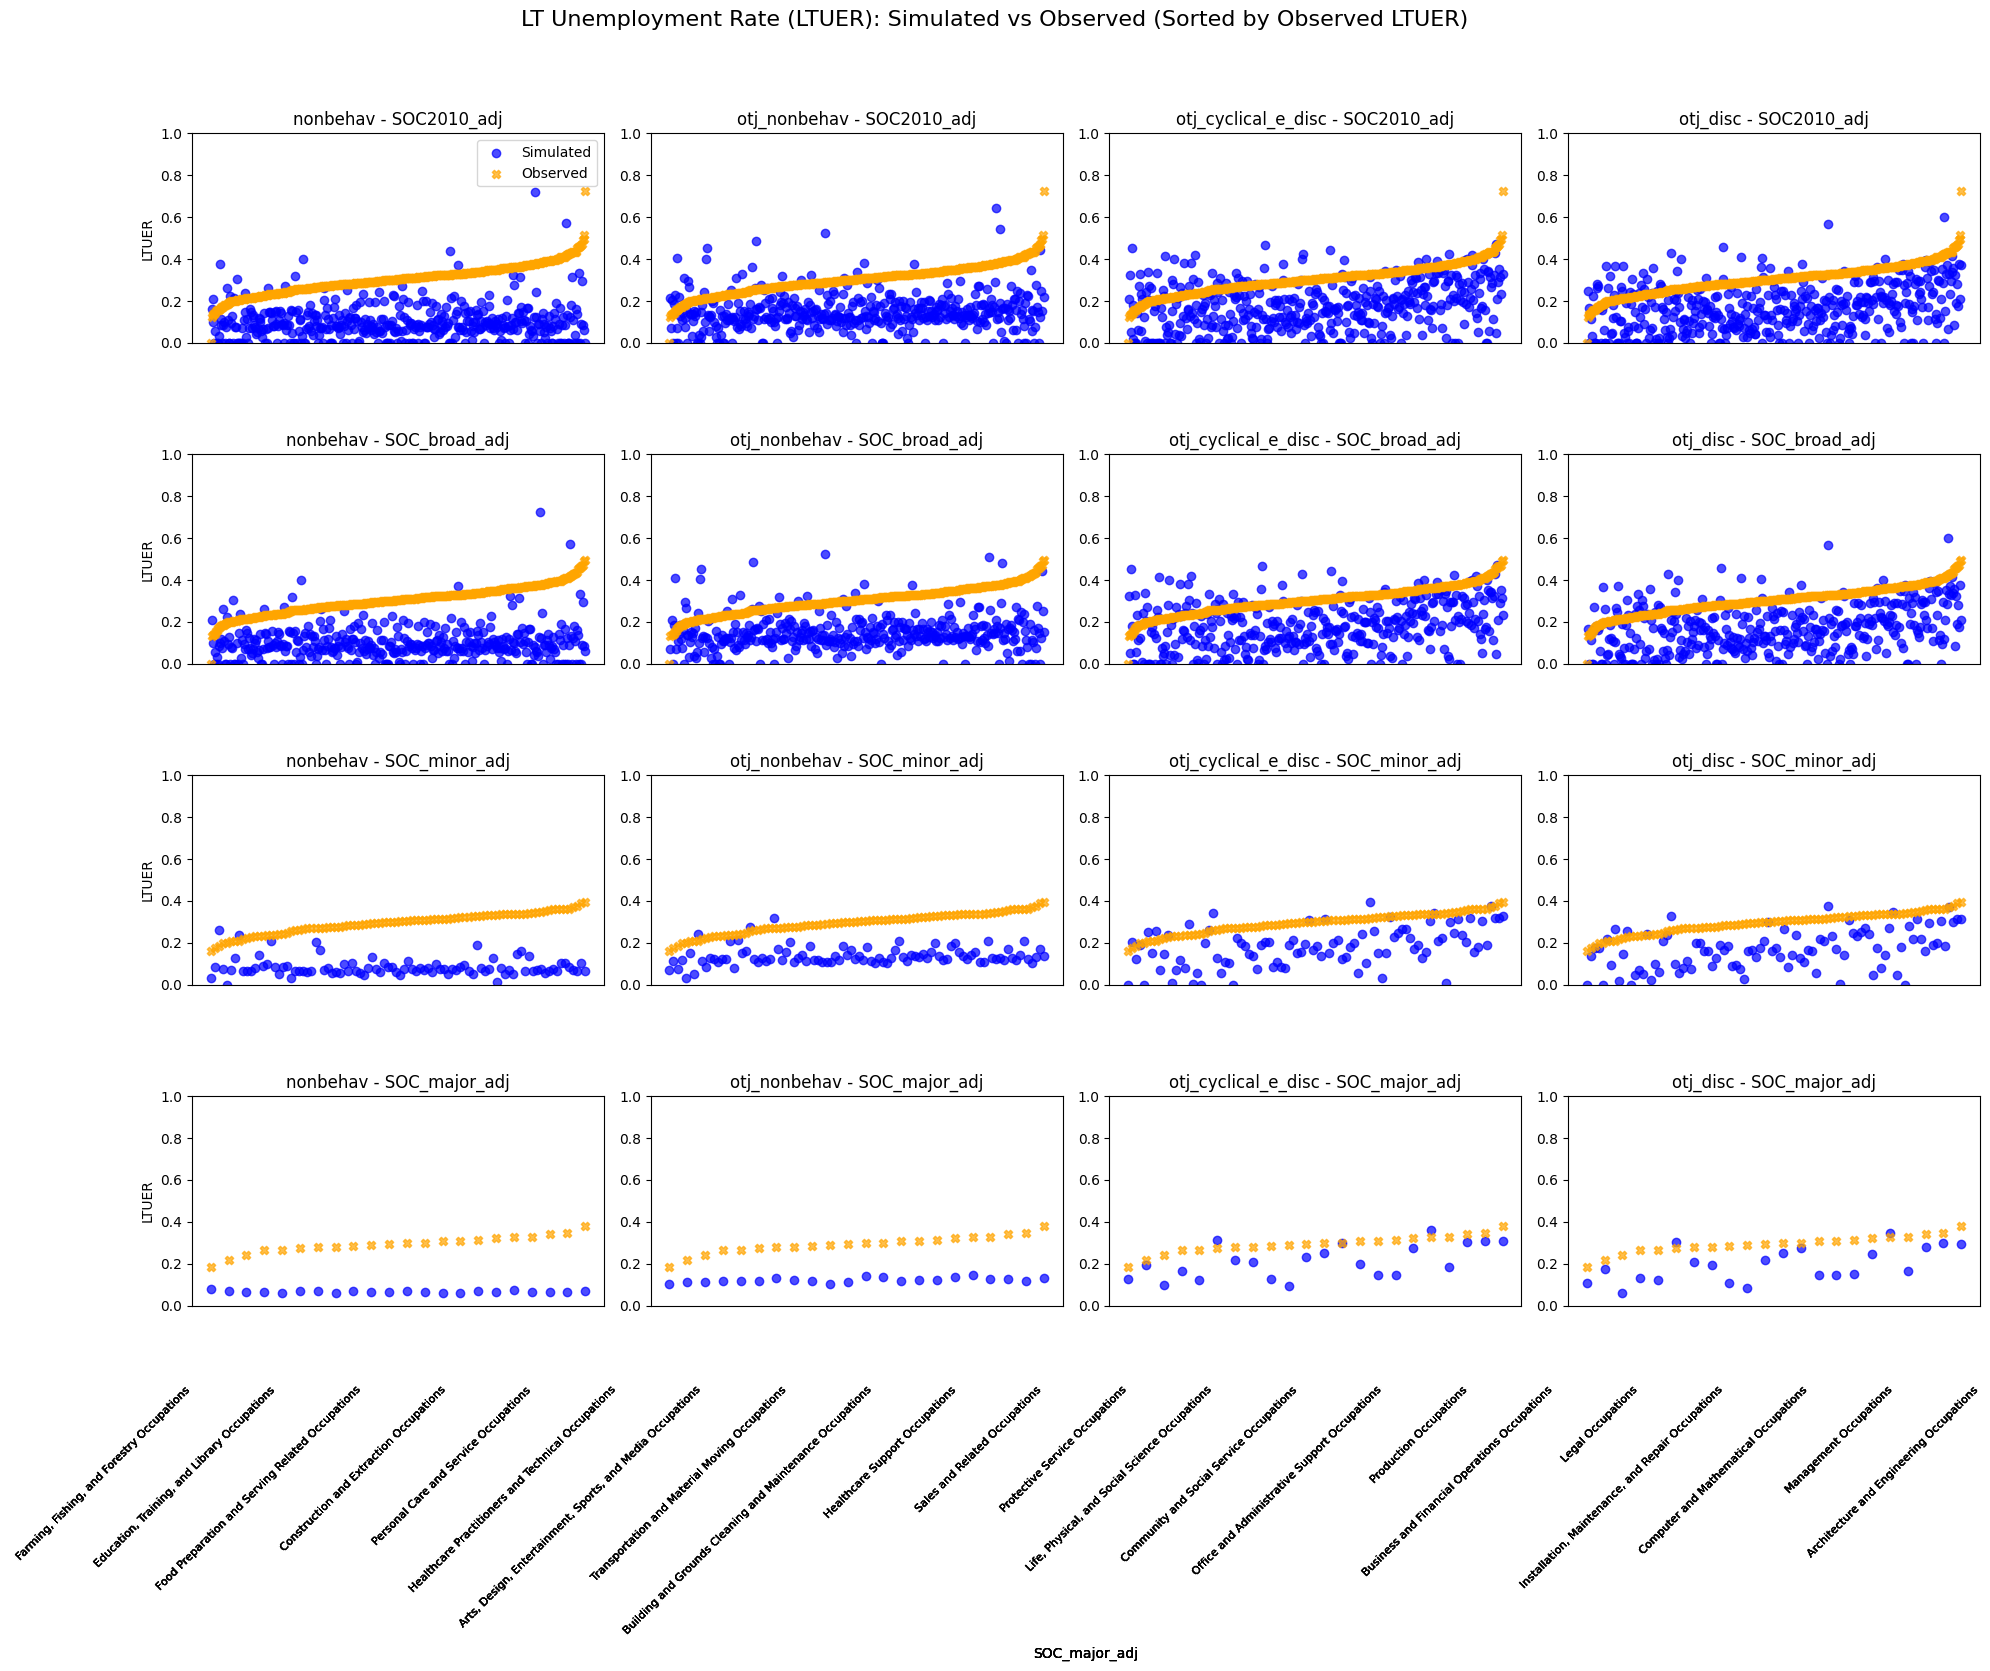

In [ ]:
# Example usage:
# occ_ltuers = pd.read_csv(path+"data/highlev_occ_ltuers.csv")
# occ_ltuers = occ_ltuers.groupby('occupation')['ltuer'].mean().reset_index()
# Pasted from data/occ_macro_vars/CPS_LTUER/occ_ltuer_observed.csv
occ_ltuer_obs = pd.read_csv(path + "data/occ_uer_ltuer_observed.csv",
    dtype={
            'SOC_major_adj': str,
            'SOC_minor_adj': str,
            'SOC_broad_adj': str,
            'SOC2010_adj': str,
        }
    )

soc_labs = pd.read_csv('/Users/ebbamark/Documents/Documents - Nuff-Malham/GitHub/transition_abm//data/occ_macro_vars/OEWS/soc_major_labels.csv', dtype={"soc_code": str})


plot_occupation_uer_grid2(filtered_sim_results, occ_ltuer_obs, soc_labs, save=save_button, path=output_path)


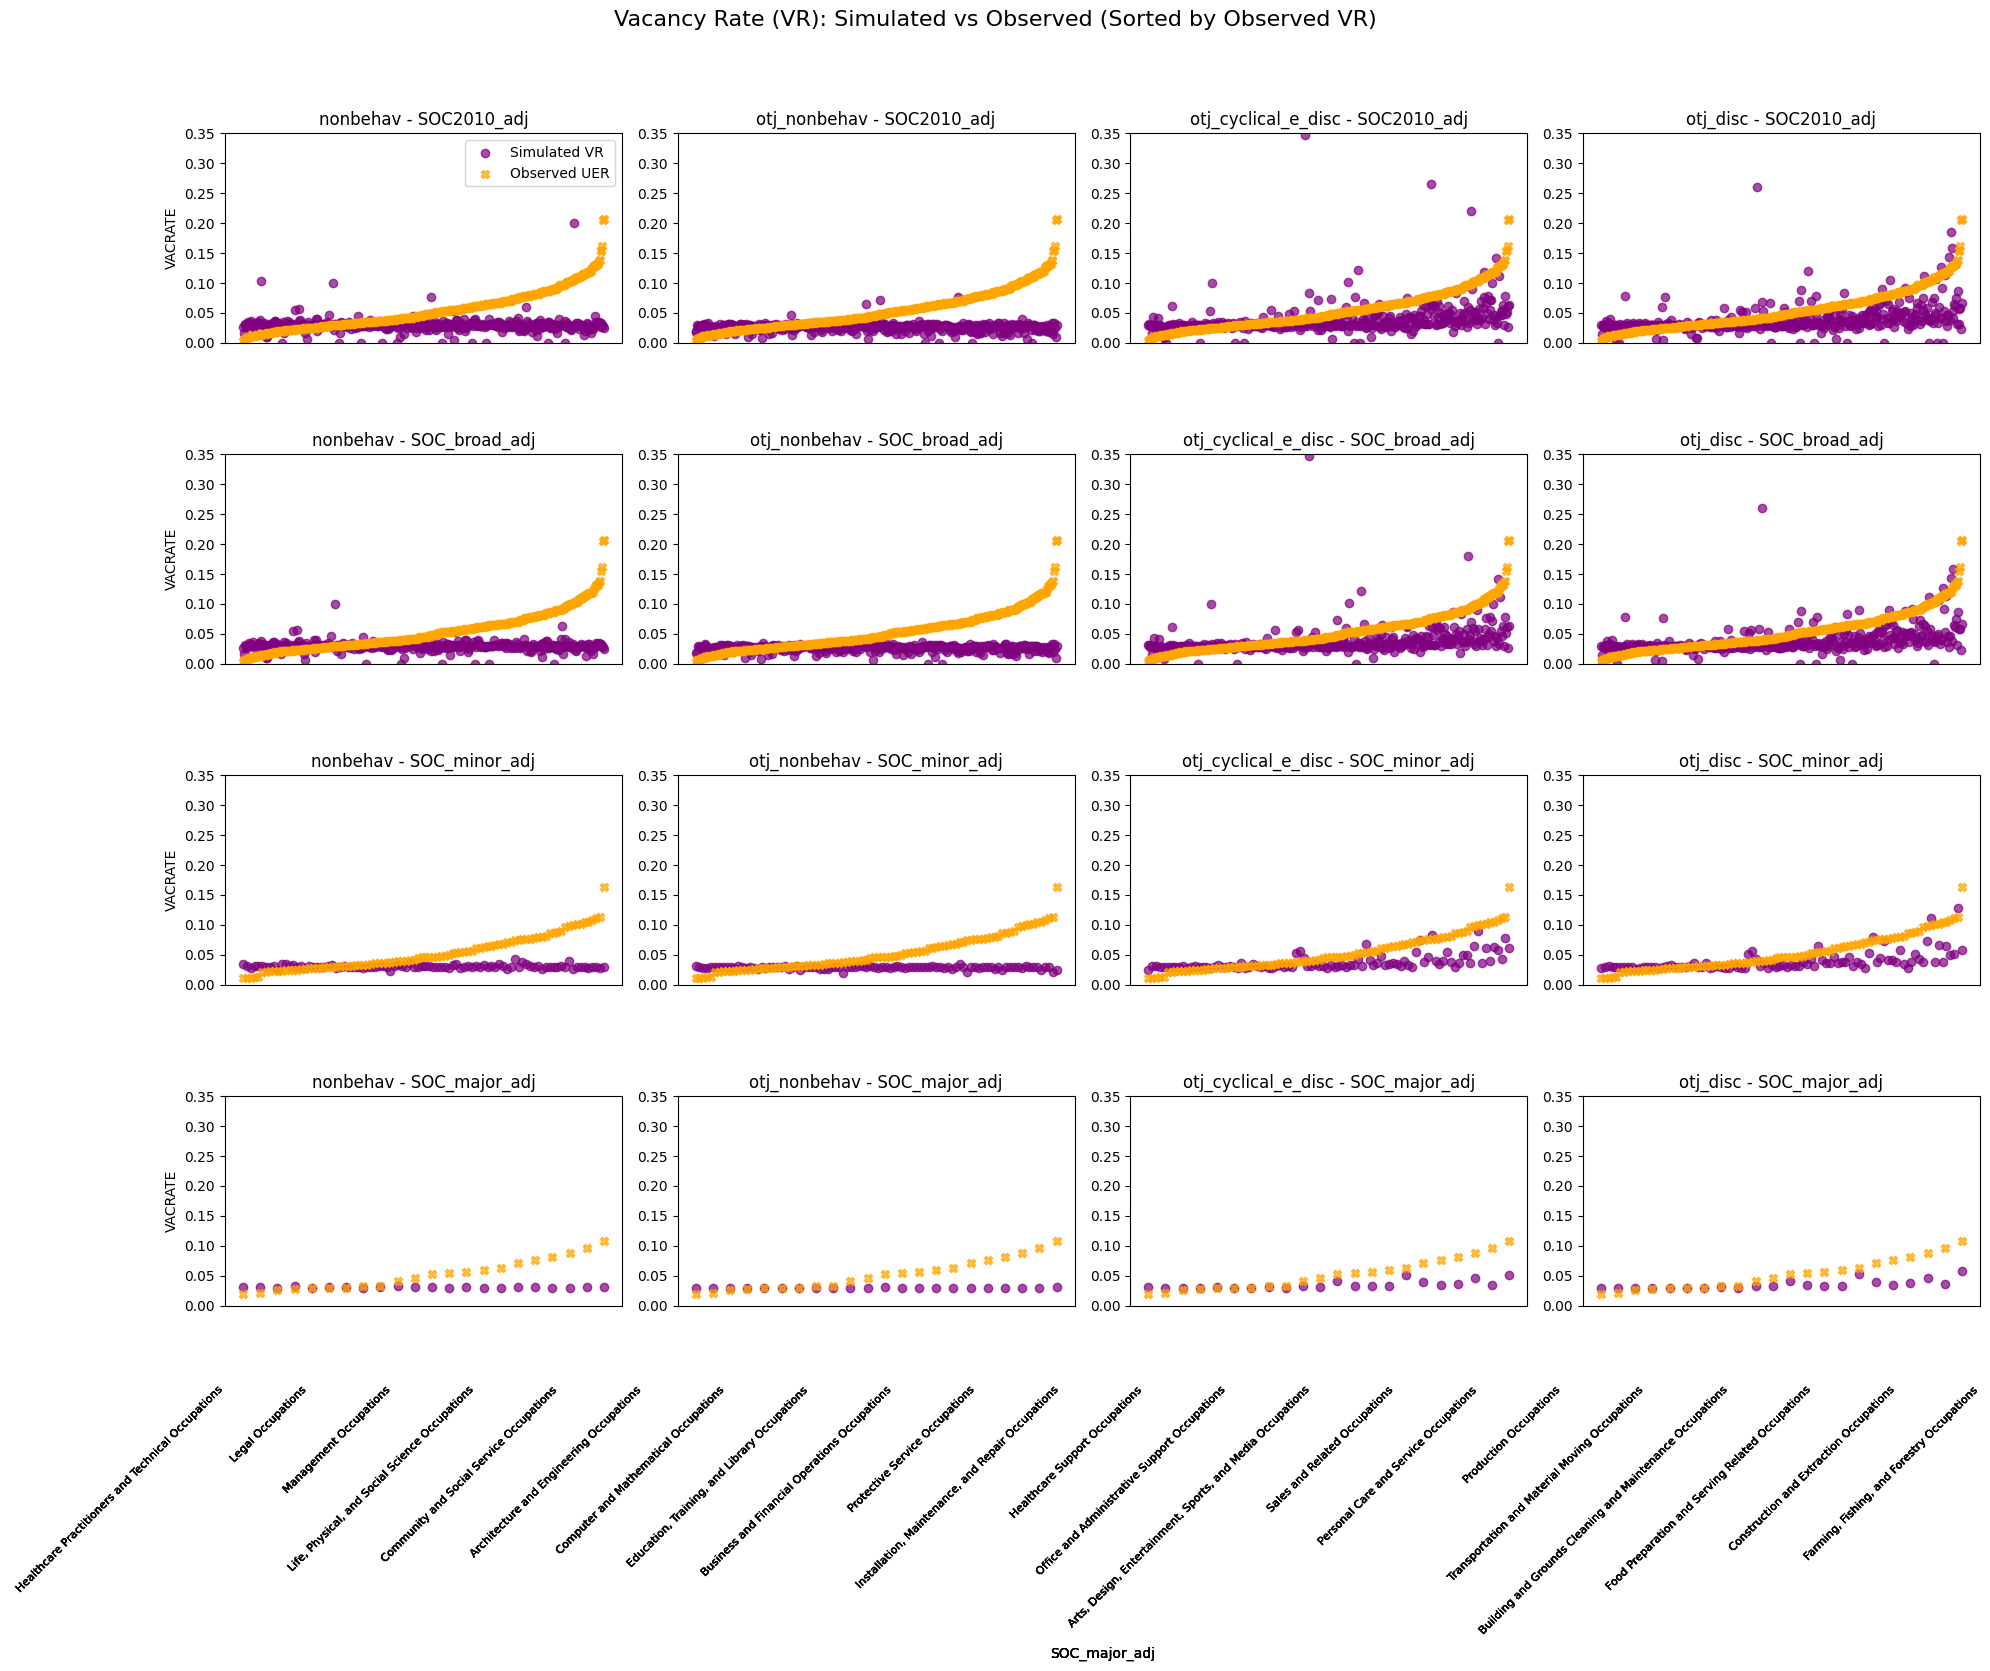

In [ ]:
def plot_occupation_vr_grid(sim_results, observation, soc_labs, save=False, path=None):
    agg_levels = {
        'SOC2010_adj': ('uer_soc2010', 'ltuer_soc2010'), 
        'SOC_broad_adj': ('uer_soc_broad', 'ltuer_soc_broad'),
        'SOC_minor_adj': ('uer_soc_minor', 'ltuer_soc_minor'), 
        'SOC_major_adj': ('uer_soc_major', 'ltuer_soc_major')
    }

    model_names = list(sim_results.keys())
    num_rows = len(agg_levels)
    num_cols = len(model_names)

    fig1 = plt.figure(figsize=(5*num_cols, 4*num_rows + 1))
    gs1 = gridspec.GridSpec(num_rows * 2, num_cols, height_ratios=[4, 0.7]*num_rows)
    fig1.suptitle("Vacancy Rate (VR): Simulated vs Observed (Sorted by Observed VR)", fontsize=16)

    for col_idx, (model_name, sims) in enumerate(sim_results.items()):
        for row_idx, (name_k, (k_uer, k_ltuer)) in enumerate(agg_levels.items()):

            temp_codes = observation.loc[:, ['acs_occ_code', name_k, k_uer, k_ltuer]]
            occ_data = sims.loc[:, ['Time Step', 'Occupation', 'acs_occ_code', 'Workers', 'Vacancies', 'Employment']]
            occ_data = occ_data.merge(temp_codes, on='acs_occ_code', how='left')

            occ_data = occ_data.groupby([name_k, 'Time Step']).sum().reset_index()
            occ_data['VACRATE'] = occ_data['Vacancies'] / (occ_data['Vacancies'] + occ_data['Employment'])

            mean_occ_data = occ_data.groupby(name_k)[['VACRATE']].mean().reset_index()
            obs_values = observation[[name_k, k_uer, k_ltuer]].drop_duplicates(subset=[name_k])
            merged = mean_occ_data.merge(obs_values, on=name_k, how='left')

            if name_k == "SOC_major_adj":
                merged[name_k] = merged[name_k].astype(str)
                soc_labs["soc_code"] = soc_labs["soc_code"].astype(str)
                merged = merged.merge(soc_labs, left_on=name_k, right_on="soc_code", how="left")
                merged[name_k + "_label"] = merged["label"]
            else:
                merged[name_k + "_label"] = merged[name_k].astype(str)

            sorted_codes_uer = merged.sort_values(by=k_uer)[name_k].tolist()
            sim_vals = merged.set_index(name_k).reindex(sorted_codes_uer)['VACRATE'].tolist()
            obs_vals = merged.set_index(name_k).reindex(sorted_codes_uer)[k_uer].tolist()
            x_ticks = list(range(len(sorted_codes_uer)))
            x_labels = merged.set_index(name_k).reindex(sorted_codes_uer)[name_k + "_label"].tolist()

            # PLOT subplot
            ax1 = fig1.add_subplot(gs1[row_idx * 2, col_idx])
            ax1.scatter(x_ticks, sim_vals, color='purple', label='Simulated VR', alpha=0.7)
            ax1.scatter(x_ticks, obs_vals, color='orange', label='Observed UER', alpha=0.7, marker='X')
            ax1.set_title(f"{model_name} - {name_k}")
            ax1.set_ylim(0, 0.35)
            ax1.set_xticks([])
            ax1.set_xticklabels([])
            if col_idx == 0:
                ax1.set_ylabel('VACRATE')
            if row_idx == 0 and col_idx == 0:
                ax1.legend()


        # LABELS subplot (one per row, after all cols)
    
        label_ax1 = fig1.add_subplot(gs1[row_idx * 2 + 1, :])  # spans all columns
        label_ax1.set_xticks(x_ticks)
        label_ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)
        label_ax1.set_yticks([])
        label_ax1.tick_params(axis='x', which='both', length=0)
        label_ax1.set_frame_on(False)
        label_ax1.set_xlabel(name_k)

    fig1.tight_layout(rect=[0, 0, 1, 0.95])

    if save:
        fig1.savefig(f'{path}occupation_vr_grid.png', dpi=300)
    plt.show()

plot_occupation_vr_grid(filtered_sim_results, occ_ltuer_obs, soc_labs, save=save_button, path=output_path)


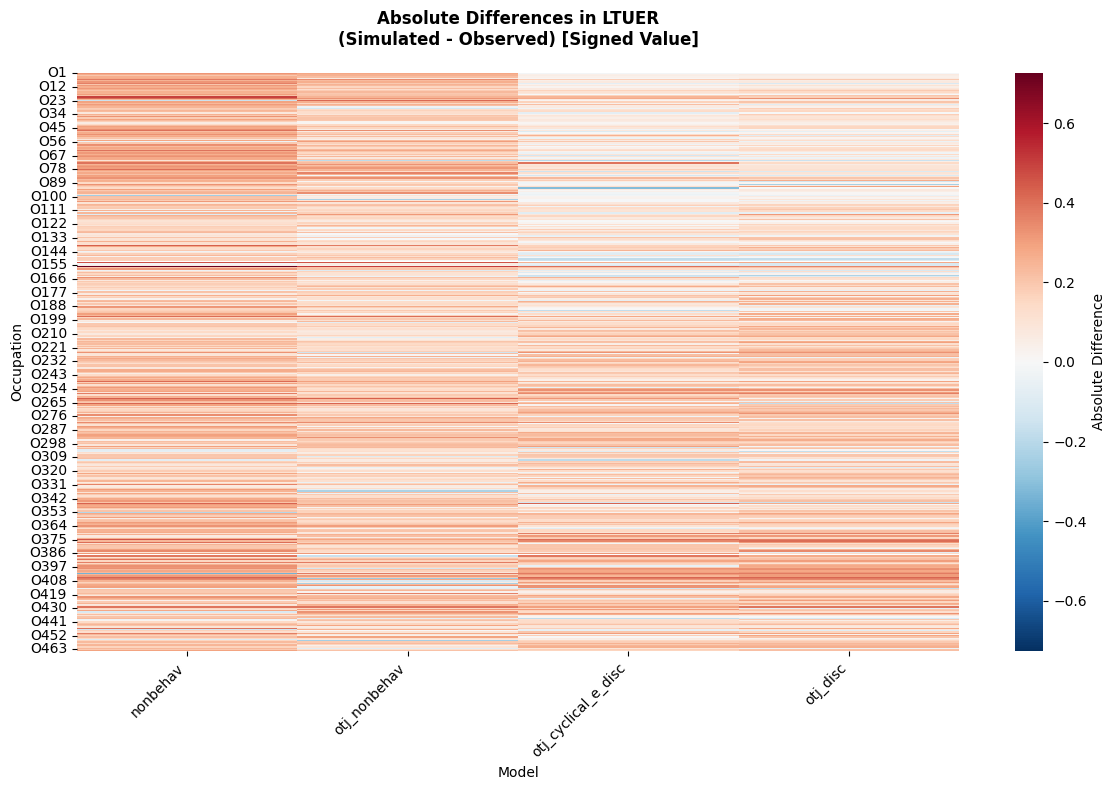

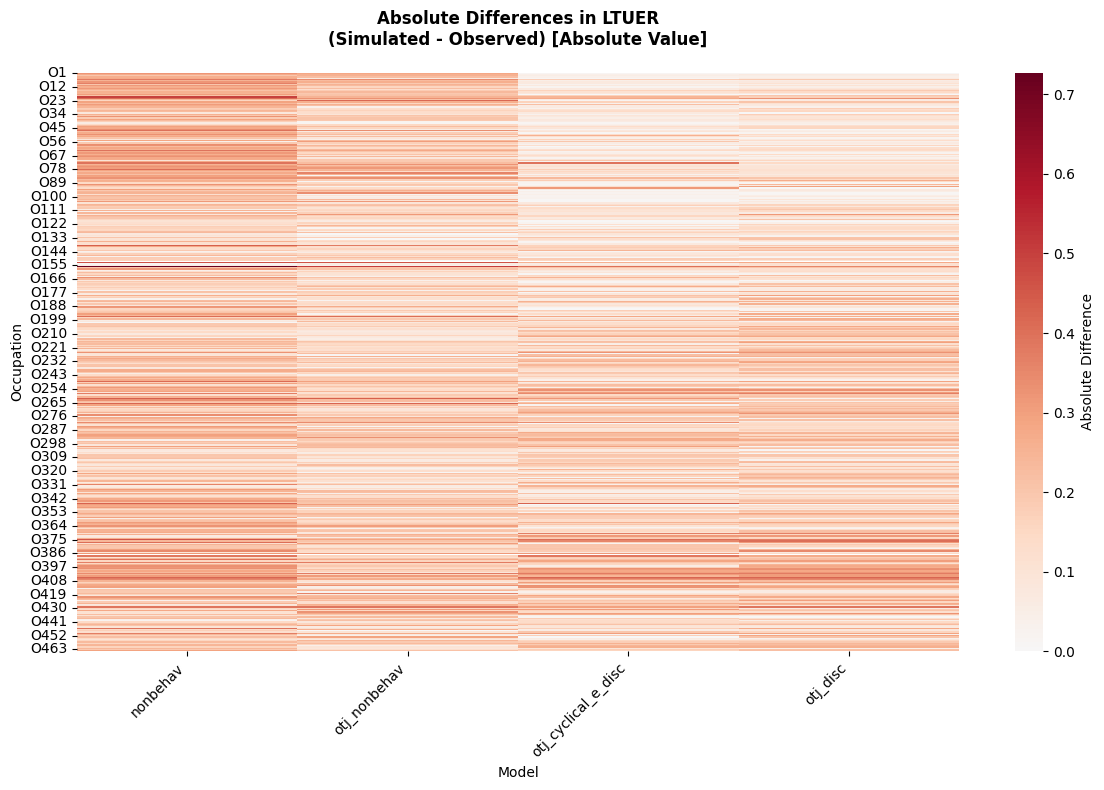

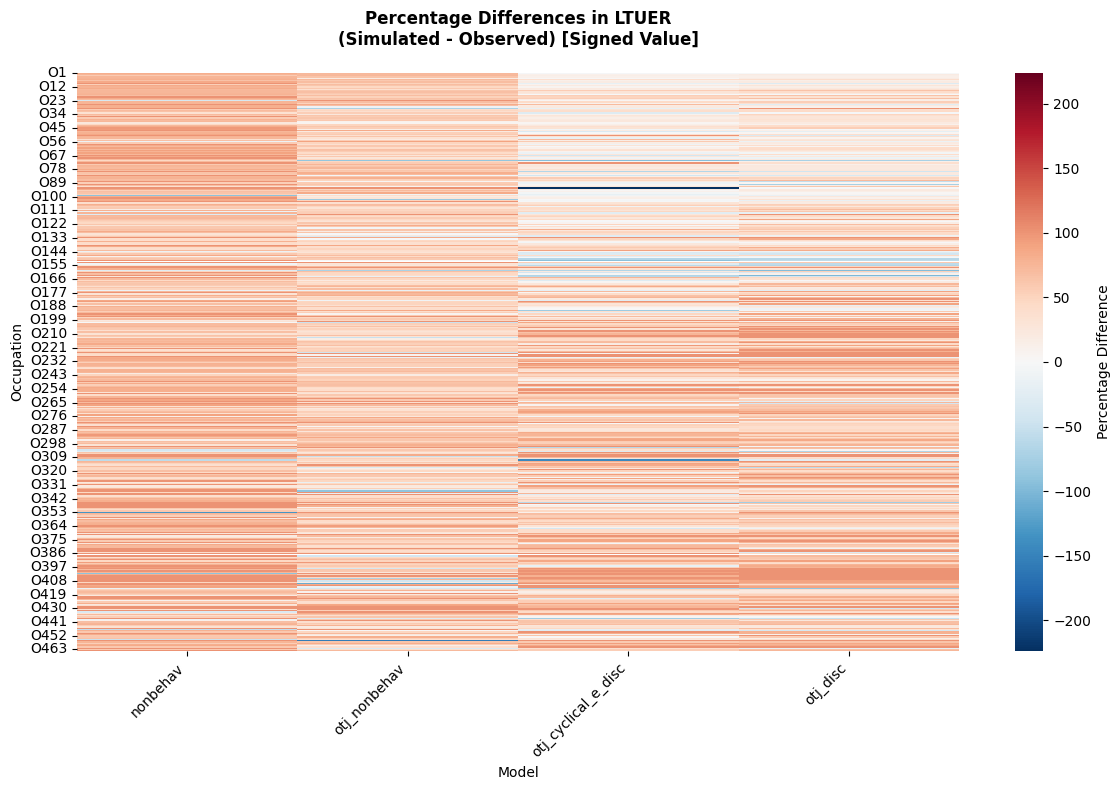

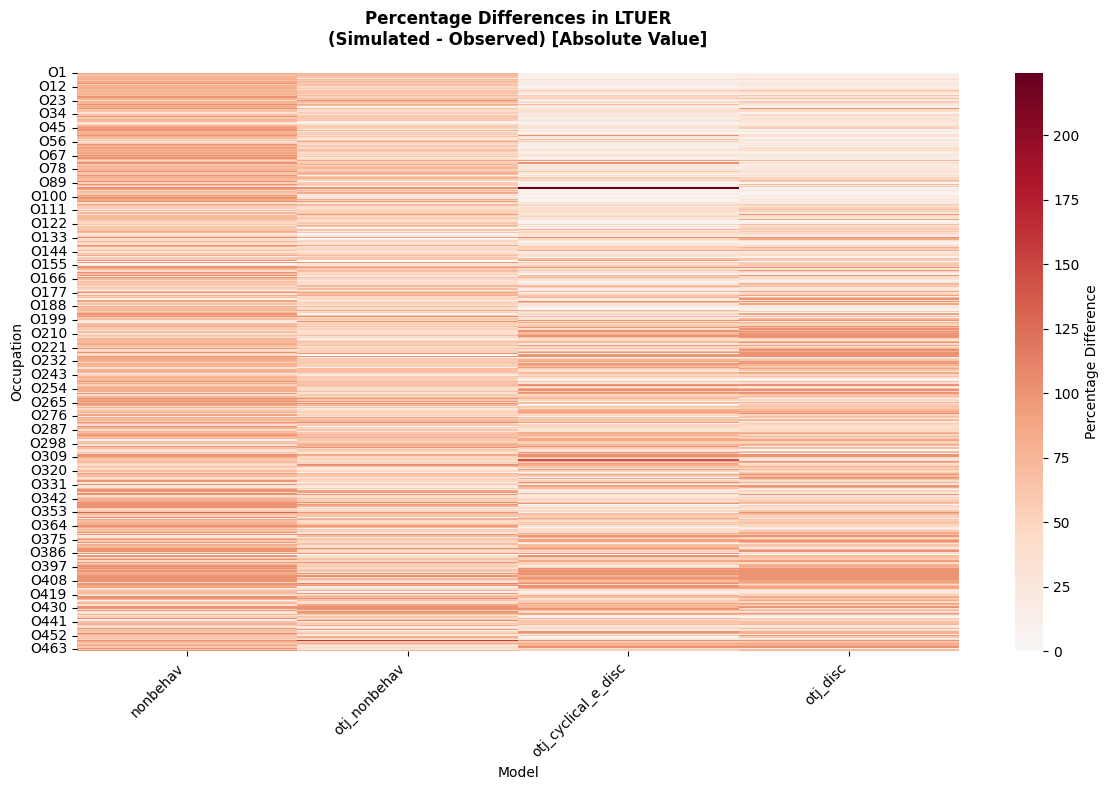

In [ ]:
for i in {'absolute', 'percentage'}:
    for j in {True, False}:
         plot_ltuer_difference_heatmap(filtered_sim_results, occ_ltuer_obs, difference_type = i, abs_value = j, save=save_button, path=output_path)

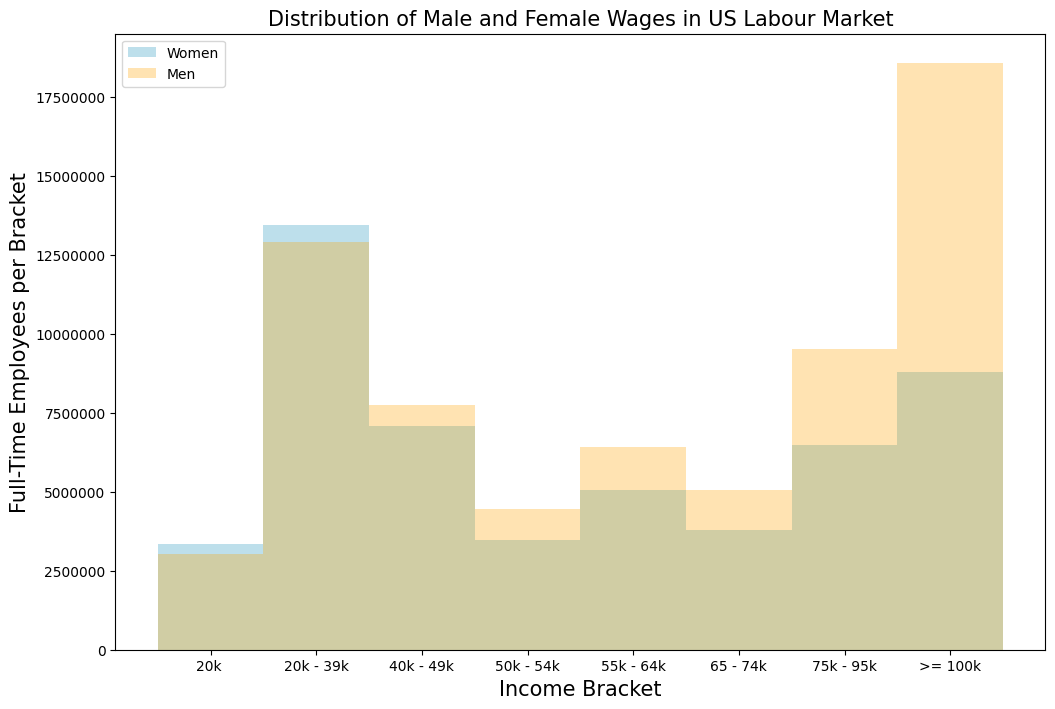

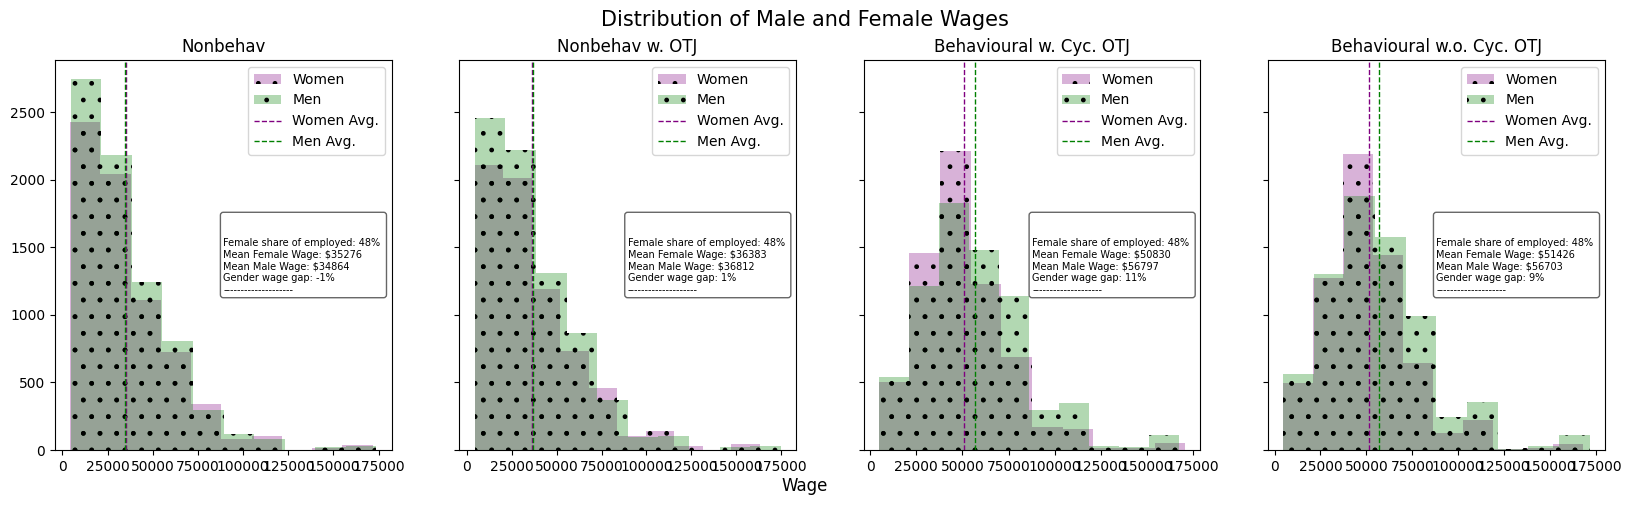

In [ ]:

gender_income = pd.read_csv(path+"data/gender_income_distribution_usa_2022.csv", delimiter=',', thousands = ",")

gender_income['Income Bracket'] = gender_income['Income Bracket'].str.replace(' or loss', '')
gender_income['Income Bracket'] = gender_income['Income Bracket'].str.replace(' or more', '')
gender_income['Ceiling'] = gender_income['Income Bracket'].str[-7:]
gender_income['Ceiling'] = gender_income['Ceiling'].str.replace(',', '')
gender_income['Ceiling'] = gender_income['Ceiling'].str.replace('$', '')
gender_income['Ceiling'] = gender_income['Ceiling'].str.replace(' ', '')
gender_income['Ceiling'] = gender_income['Ceiling'].astype('Int64')
gender_income.loc[0:7, 'Bracket'] = "20k "
gender_income.loc[8:12, 'Bracket'] = "20k - 39k"
gender_income.loc[13:14, 'Bracket'] = "40k - 49k"
gender_income.loc[15, 'Bracket'] = "50k - 54k"
gender_income.loc[16, 'Bracket'] = "55k - 64k"
gender_income.loc[17, 'Bracket'] = "65 - 74k"
gender_income.loc[18, 'Bracket'] = "75k - 95k"
gender_income.loc[19, 'Bracket'] = ">= 100k"
brackets = gender_income.groupby(['Bracket']).sum().reset_index()

barWidth = 1
fig = plt.subplots(figsize =(12, 8)) 
br1 = np.arange(len(brackets['Bracket'])) + 1
br2 = br1
 
# Make the plot
plt.bar(br1, brackets['Full-Time Females'], color ='lightblue', width = barWidth, alpha = 0.8,
         label ='Women') 
plt.bar(br2, brackets['Full-Time Males'], color ='orange', width = barWidth, alpha = 0.3,
        label ='Men') 


# Adding Xticks 
plt.xlabel('Income Bracket', fontsize = 15) 
plt.ylabel('Full-Time Employees per Bracket', fontsize = 15) 
plt.ticklabel_format(useOffset=False, style='plain')
plt.xticks([r + barWidth for r in range(len(brackets['Bracket']))], 
        brackets['Bracket'])

plt.title('Distribution of Male and Female Wages in US Labour Market', fontsize = 15) 
plt.legend()
plt.show() 

womens_wage = (gender_income['Ceiling'] * gender_income['Full-Time Females']).sum()/(gender_income['Full-Time Females'].sum())
mens_wage = (gender_income['Ceiling'] * gender_income['Full-Time Males']).sum()/(gender_income['Full-Time Males'].sum())

plot_gender_gaps(filtered_net_results, names = ["Nonbehav", "Nonbehav w. OTJ", "Behavioural w. Cyc. OTJ","Behavioural w.o. Cyc. OTJ"], save = True, path = output_path)


In [ ]:
from PIL import Image, ImageDraw, ImageFont

def combine_model_images(image_dir, calib_list, sep_strings, output_path="combined_calibration.png"):
    # Load images into groups
    grouped = {match: [] for match, _ in sep_strings}
    titles = {match: title for match, title in sep_strings}
    unmatched = []

    for model_name in calib_list.keys():
        filename = f'{path}output/calibration_{model_name}_sim_results.png'
        filepath = os.path.join(image_dir, filename)
        if not os.path.exists(filepath):
            continue

        img = Image.open(filepath)
        matched = False
        for match, _ in sep_strings:
            if match in model_name:
                grouped[match].append((model_name, img))
                matched = True
                break
        if not matched:
            unmatched.append((model_name, img))

    if unmatched:
        grouped["__unmatched__"] = unmatched
        titles["__unmatched__"] = "Other Models"

    # === Font and Layout Configuration ===
    title_font_size = 80
    name_font_size = 60

    title_height = title_font_size + 20
    name_height = name_font_size + 10
    spacing = 20

    try:
        font = ImageFont.truetype("arial.ttf", name_font_size)
        title_font = ImageFont.truetype("arial.ttf", title_font_size)
    except:
        font = ImageFont.load_default()
        title_font = font

    # Safely get size of the first available image
    first_img = None
    for models in grouped.values():
        if models:
            first_img = models[0][1]
            break

    if first_img is None:
        raise ValueError("No images found in any group.")

    img_width, img_height = first_img.size

    # === Canvas Size Calculation ===
    num_cols = len(grouped)
    max_rows = max(len(models) for models in grouped.values())

    total_width = num_cols * (img_width + spacing)
    total_height = max_rows * (img_height + name_height + spacing) + title_height

    combined_img = Image.new("RGB", (total_width, total_height), color="white")
    draw = ImageDraw.Draw(combined_img)

    # === Drawing images and text ===
    for col, (match, models) in enumerate(grouped.items()):
        x_offset = col * (img_width + spacing)

        # Column title
        title_text = titles[match]
        text_width = draw.textlength(title_text, font=title_font)
        draw.text((x_offset + (img_width - text_width) // 2, 5), title_text, fill="black", font=title_font)

        for row, (name, img) in enumerate(models):
            y_offset = title_height + row * (img_height + name_height + spacing)

            # Model name
            name_text_width = draw.textlength(name, font=font)
            draw.text((x_offset + (img_width - name_text_width) // 2, y_offset), name, fill="black", font=font)

            # Paste image
            combined_img.paste(img, (x_offset, y_offset + name_height))

    # === Save the result ===
    combined_img.save(output_path)
    print(f"Combined image saved to {output_path}")

combine_model_images(
    image_dir=f'{path}output/',
    calib_list=calib_list,
    sep_strings=[
        ("nonbehav", "Non-behavioural w. and w.o OTJ"),
        ("ue", "Cyclical UE SE")
    ],
    output_path="all_calibrations_combined_today.png"
)

ValueError: No images found in any group.